# CNN-based sentiment classifier
The code below illustrates a working example of a CNN-based sentiment classifier. The data used to train the model is from coursework assignment 1.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.utils import shuffle
import pandas as pd
from sklearn.utils import shuffle
import nltk
nltk.download('punkt')

df = pd.read_table('/content/drive/My Drive/Colab Notebooks/coursework2_train.tsv')
df = shuffle(df) # randomly shuffle data entries 
#df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Why I Choose 300 dimensional Word Embeddings from Glove

I use word embeddings from glove because training your own embeddings takes a while. Second, the embeddings from glove from a much more expansive vocabulary as they are trained upon a much greater amount of data. It is more likely for a vocabulary word in the test set to be missing if I were to use my own embeddings. We would then have to replace this with an "oov" or random vector which would only add noise to the data, harming the predictive power of our models. 

I use the 300 dimensional embeddings from glove because these vectors possess more specificity by storing more information. 


In [4]:
# load pre-trained glove embeddings
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# specify the loaction of the downloaded glove file
path_of_downloaded_files = "/content/drive/My Drive/Colab Notebooks/glove.6B.300d.txt"
glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Below is the vectorizer for the convolutional neural network. It is taken from lab 8.2. 

In [0]:
# define functions that build mini-batches
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics import confusion_matrix

word_vec_dim = 300 # make sure this number matches the embedding you use

# Out-of-vocabulary (OOV) words: words that are not included in the pre-trained embedding model
# There exist many ways to vectorize OOV words, e.g. use a random vector to represent all OOV words
# Feel free to search and employ other ways to vectorize OOV words
oov_vec = np.random.rand(word_vec_dim)

def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    for i in range(largest_len-len(sent_words)):
        vecs.append([0.]*word_vec_dim)
    return np.array(np.transpose(vecs))

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs.append(vv)
    # print('mini batch shape',np.array(text_vecs).shape)
    return np.array(text_vecs)
  
# sanity check 
#batch = build_mini_batch(['hello world!','HELLO','this is a long sentence!'], word_vectors)#.shape
#word_vectors

## Why We Use Convolutional Neural Network for Our Neural Model

 We use a CNN as our neural model. While a LSTM network generally yields better performance than CNN for text classification, the text we are given is not very long, so we choose a CNN due to the fact that it is computationally faster, and overall performance does not differ significantly with LSTM. Second, LSTM is generally better for long texts as it can capture long-range relationships between words much better than other models. However, if you look closely at the propoganda dataset, much of the text is not long at all, and using a CNN with many kernels and filters can actually be more powerful than using an LSTM network. By having a lot o kernels and filters, it is able to capture relationships up among groups of words; second, by having many filters, it can capture many different types of relationships amongst these groups of words. 

In [0]:
# define the CNN1 model (as taken from lab 8.2)

import numpy as np
import torch
import torch.nn as nn

class CNN_Clf(nn.Module):
    def __init__(self, embd_dim, filter_size_list, filter_num_list, class_num, dp_rate=0.5, gpu=False):
        super(CNN_Clf, self).__init__()
        self.embd_dim = embd_dim
        assert len(filter_size_list) == len(filter_num_list)
        self.output_dim = class_num
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dp_rate)
        self.fc = nn.Linear(np.sum(filter_num_list), class_num)
        self.gpu = gpu
        self.convs = self.build_convs(filter_size_list, filter_num_list, gpu)
        if self.gpu:
            self.to('cuda')
            
    def build_convs(self, f_sizes, f_nums, gpu):
        convs = nn.ModuleList()
        for fs, fn in zip(f_sizes, f_nums):
            padding_size = fs-1
            m = nn.Conv1d(self.embd_dim, fn, fs, padding=padding_size)
            if gpu: m.to('cuda')
            convs.append(m)
        return convs
        
    def get_conv_output(self, input_matrix, conv, gpu):
        # step 1: compute convolution 
        assert input_matrix.shape[1] == self.embd_dim
        conv_output = conv(input_matrix)
        # step 2: pass through an activation function 
        conv_relu = self.tanh(conv_output)
        # step 3: max-over-time pooling
        maxp = nn.MaxPool1d(conv_relu.shape[2])
        maxp_output = maxp(conv_relu)
        return maxp_output
       
    def forward(self, all_text_vectors):
        cnn_repr = torch.tensor([])
        if self.gpu: cnn_repr = cnn_repr.to('cuda')
        for cv in self.convs:
            cv_output = self.get_conv_output(all_text_vectors, cv, self.gpu)
            cnn_repr = torch.cat((cnn_repr, cv_output), dim=1)
        # print(cnn_repr.shape)
        after_dp = self.dropout(cnn_repr.squeeze())
        logit = self.fc(after_dp)
        # the CrossEntropyLoss provided by pytorch includes softmax; so you do not need to include a softmax layer in your net
        return logit
#word_vectors['hello']

In [7]:
## Converting the data into lists, splitting between text data and title data

raw_labels = df.label.values.tolist()
docs = df.sentence_text.values.tolist()
titles = df.article_title.values.tolist()

label_dic = {'non-propaganda':0, 'propaganda':1}

assert len(docs) == len(raw_labels) == len(titles)
labels = [label_dic[rl] for rl in raw_labels] # transfer raw labels (strings) to integer numbers
print('total data size: {}, label type num: {}'.format(len(docs), len(label_dic)))
#docs

total data size: 11464, label type num: 2


# Cleaning the Data: Why We Don't Remove Stop Words and Why we Don't Lemmatize/Stem

For a CNN, relationships among groups of words are important because the kernels (and for each kernel multiple filters) capture relationships amongst groups of words. Thus, it is not a good idea to blindly remove stop words. Removing stopwords could affect these intra-cluster relationships in a negative fashion. Second, stop words (like in the last assignment) standing along may not have much meaning; however, coupled with other words they are much more meaningful and that is why we should generally keep them. (For instance: not bad vs not (where "not" is the stop word). 


Lemmatizing/stemming may not be a good idea either as in doing so, we are reducing the specifity of our sentences, which will ultimately reduce are predictive power. It is no question that tense plays a strong role in affecting with a text is written in the active voice or passive voice, which affects the tone of the text. Tone, here, is very useful in determining whether something is propaganda or not. Religious texts, for example, have a very commanding tone (and many have active voice) as much of these texts are written in the form of rules that one must follow. If we were to lemmatize these texts, then propaganda texts and non-propaganda texts would be harder to distinguish from one another. 

Therefore, the only thing we do in are data cleaning is to lowercase all the words and remove punctuation.



In [0]:
import re
import string

combined = []
for tits, dics in zip(titles, docs):
    combined.append(tits + " " + dics)
#combined2 = [" ".join(ss) for ss in combined]

combined3 = []
for sent in combined:
 combined3.append(" ".join(re.findall('\w+', sent.lower())))


## Data Exploration

### Further rudimentary data exploration yields the following information:

--> 1) The average length of non-progaganda texts are much longer. 

--> 2) The dataset is highly imbalanced. We will need to take this into account when we split our data later. 

--> 3) There are many texts that have the same title --> many of these texts are from the same corpus (e.g. from the same news article). We can do two things about this: we can shuffle the data or we can somehow combine all the data with the same title into the same text document, as they all have the same labels.

In [9]:
# Comparing the length of the text between class labels for docs
array_labels = np.array(labels)
array_docs = np.array(docs)
array_titles = np.array(titles)
prop_indices = np.where(array_labels == 1)
non_prop_indices = np.where(array_labels == 0)

non_prop_docs = array_docs[non_prop_indices]
non_prop_titles = array_titles[non_prop_indices]

prop_docs = array_docs[prop_indices]
prop_titles = array_titles[prop_indices]

# We are dealing with an unbalanced dataset: 3237 vs 8227
print('propoganda count:', len(prop_docs))
print('non-progranda count:', len(non_prop_docs))

print('non-prop/prop ratio:', len(non_prop_docs)/len(prop_docs))

# Comparing the length of text between the class labels
non_prop_length = np.mean([len(i) for i in non_prop_docs])
prop_length = np.mean([len(i) for i in prop_docs])

non_prop_title_length = np.mean([len(i) for i in prop_titles])
prop_title_length = np.mean([len(i) for i in non_prop_titles])
print(" ")
print("non_prop doc length:", non_prop_length)
print("prop doc length:", prop_length)
print(" ")
print("non_prop title length:", non_prop_title_length)
print("prop title length:", prop_title_length)

propoganda count: 3237
non-progranda count: 8227
non-prop/prop ratio: 2.5415508186592524
 
non_prop doc length: 109.41205785827154
prop doc length: 152.20142106889094
 
non_prop title length: 60.803212851405625
prop title length: 64.2591467120457


# How We Split the Data

In Building a Neural Net, it is much harder to do hyperparameter such effectively as we do not have the courtesy of cross-validating since the overall process is very computationally slow. One 70/30 split of data already takes quite a while. Thus, performing a random search or grid search would be even less practical as it would take ages for the computation to complete. 

## Methodology
In consideration of time constraints, our approach to this issue is as follows:

1) First perform five 70/30 Split of Data: Since we know that the labels in our dataset are imbalanced, we use the stratify option in sklearn's train_test_split function to ensure that our validation and training sets have the same label ratio. That is, if the data yields an approximate 65% non-progranda labels to 35% progranda label  percentage, within both our training and validation sets, we want these same percentages so that both have a 65/35 non-propaganda to propoganda ratio. We do this because we do not want to induce any sampling bias into our hyper-parameter/optimal-model-selection stage. We choose 5 training/validation splits because although slow, there is too much variance at each epoch to have a trustworthy F1 metric. We need to average across splits to obtain something more meaningful.

2) Using this same training/validation splits, we randomly choose and and adjust numerous variables: n_epochs, learning_rate, number_of_filters, filter_sizes, batch_size. We observe the effect these variables have on the F1_value (in imbalanced datasets F1 is a better metric than accuracy as your model can obtain good accuracy by simply predicting one label if most of the dataset only contains that label). Specifically, we take into account two things the combination of these variables can have: first, we want to see which model yields that highest F1 Score. Secondly, we want to see which model yields the most stable F1_scores across a long range of epochs. For instance, look at the example model below (say we only run for 5 epochs given time constraints):

##### MODEL 1: {epoch 1: 45%, epoch2: 64%, epoch3: 73%, epoch4: 68%, epoch5: 67%}

##### MODEL 2 {epoch 1: 45%, epoch2: 71%, epoch3: 70%, epoch4: 71%, epoch5: 70%}

Which model is better? Despite the fact that Model 1 yields the higher F1 score, model 2 is better because it yields a more stable, longer range of higher values. This is a better property to have because training validation splits are subject to a lot of variance. Just because we have 73% at epoch 3 at for model 1 does not mean that we can obtain this same score on a different validation set. Therefore model 2 is better, it provides a steadier range of higher values so that we are better guarunteed a good F1_score for difference splits of data. For instance, say we choose to train our model for 4 epochs: we hoping to hit a 71% F1 score. Even if we don't hit this score, we will be in a safe zone where we will likely to end up with 70% (because it range of values of its surrounding epochs are all close to 71). However, in model 1, if choose to train for 3 epochs (tryin to hit 73%), we are in a dangerous spot because if we do not hit 73%, we are likely to hit 64% or 68% (because the range of values of its surrounding epochs are low). 

In [0]:
#Splitting the data

from sklearn.model_selection import train_test_split
x_train1, x_dev1, y_train1, y_dev1 = train_test_split(combined3, labels,  train_size = 0.7, test_size = 0.3, stratify = labels, random_state = 453)

x_train2, x_dev2, y_train2, y_dev2 = train_test_split(combined3, labels,  train_size = 0.7, test_size = 0.3, stratify = labels, random_state = 144)

x_train3, x_dev3, y_train3, y_dev3 = train_test_split(combined3, labels,  train_size = 0.7, test_size = 0.3, stratify = labels, random_state = 28)

x_train4, x_dev4, y_train4, y_dev4 = train_test_split(combined3, labels,  train_size = 0.7, test_size = 0.3, stratify = labels, random_state = 186)

x_train5, x_dev5, y_train5, y_dev5 = train_test_split(combined3, labels,  train_size = 0.7, test_size = 0.3, stratify = labels, random_state = 27)


# dev_docs = x_dev
# train_docs = x_train
# train_labels = y_train
# dev_labels = y_dev

# All splits of data inserted into lists
train_docs_list = [x_train1, x_train2, x_train3, x_train4, x_train5]
dev_docs_list = [x_dev1, x_dev2, x_dev3, x_dev4, x_dev5]
train_labels_list = [y_train1, y_train2, y_train3, y_train4, y_train5]
dev_labels_list = [y_dev1, y_dev2, y_dev3, y_dev4, y_dev5]

# Below we are Training the Model as Described Before

We are doing this 5 times, saving the model's ouputs to an array.

We obtain five of these arrays and then take an average in order to obtain more stable F1_Scores

We randomly adjust the hyperparameters as well as the number of filters and filter sizes to find an optimal model


In [115]:
# training the CNN model

best_f1 = -1.
#best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm

f1_f1_list = []
for train_docs, dev_docs, train_labels, dev_labels in zip(train_docs_list , dev_docs_list , train_labels_list ,dev_labels_list):
  f1_list = []
  #***********************************************************#
  ## We vary the below values.
  dropout_rate = 0.5 # dropout rate
  filter_sizes = [1,2,3,4, 5, 6]
  filter_nums = [200]*len(filter_sizes)

  # hyper parameters
  n_epochs = 50 # number of epoch (i.e. number of iterations)
  batch_size = 50
  lr = 0.0008

  #************************************************************#
  gpu = True # whether use gpu to accelerate the training
  model = CNN_Clf(word_vec_dim, filter_sizes, filter_nums, 2, dropout_rate, gpu)
  loss_fnc = torch.nn.CrossEntropyLoss() # cross entropy loss

# init optimizer and scheduler (lr adjustor)
  import torch.optim as optim
  optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95) # after each epoch, the learning rate is discounted to its 95%
  for epoch_i in tqdm(range(n_epochs)):
      # the inner loop is over the batches in the dataset
      model.train() # let pytorch know that gradients should be computed, so as to update the model
      ep_loss = []
      for idx in range(0,len(train_docs),batch_size):
          # Step 0: Get the data
          x_data = build_mini_batch(train_docs[idx:idx+batch_size], word_vectors)
          if x_data.shape[0] == 0: continue # to avoid empty batch
          y_target = torch.tensor([train_labels[idx:idx+batch_size]], dtype=torch.int64).squeeze()
          if gpu:
              y_target = y_target.to('cuda')
          
          # Step 1: Clear the gradients 
          optimizer.zero_grad()

          # Step 2: Compute the forward pass of the model
          x_tensor = torch.tensor(x_data, dtype=torch.float)
          if gpu:
              x_tensor = x_tensor.to('cuda')
          y_pred = model(x_tensor)
          pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
          # print('pred labels', pred_labels)
          # print('true labels', y_target)

          # Step 3: Compute the loss value that we wish to optimize
          loss = loss_fnc(y_pred, y_target)
          # print(loss)
          ep_loss.append(loss.cpu().detach().numpy())

          # Step 4: Propagate the loss signal backward
          loss.backward()

          # Step 5: Trigger the optimizer to perform one update
          optimizer.step()
      
      print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
      
      # after each epoch, we can test the model's performance on the dev set
      with torch.no_grad(): # let pytorch know that no gradient should be computed
          model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
          dev_predictions = []
          for idx in range(0,len(dev_docs),batch_size):
              x_data = build_mini_batch(dev_docs[idx:idx+batch_size], word_vectors)
              if x_data.shape[0] == 0: continue # to avoid empty batch
              x_tensor = torch.tensor(x_data, dtype=torch.float)
              if gpu:
                  x_tensor = x_tensor.to('cuda')
              y_pred = model(x_tensor).cpu().detach().numpy()
              pred_labels = [np.argmax(entry) for entry in y_pred]
              dev_predictions += pred_labels
              # print(pred_labels)
          pre, rec, f1, _ = precision_recall_fscore_support(dev_labels, dev_predictions,average='macro')
          f1_list.append([f1])
          print('\n---> after epoch {} the macro-F1 on dev set is {}'.format(epoch_i, f1))
          print("Accuracy is:", np.sum(np.array(dev_labels) == np.array(dev_predictions))/len(dev_labels))
          for param_group in optimizer.param_groups:
              print('learning rate', param_group['lr'])
          
          # save the best model. NOTE: Just because the model yields the highest f1_score does not mean we will use this model. 
          if f1 > best_f1:
              best_f1 = f1
              best_model = copy.deepcopy(model.state_dict())
              print('best model updated; new best macro-F1',f1)
      
      # (optional) adjust learning rate according to the scheduler
      scheduler.step()
      f1_f1_list.append([f1_list])

  0%|          | 0/50 [00:00<?, ?it/s]


======epoch 0 loss====== 0.5603994


  2%|▏         | 1/50 [00:12<10:30, 12.87s/it]


---> after epoch 0 the macro-F1 on dev set is 0.610439339304598
Accuracy is: 0.7575581395348837
learning rate 0.0008
best model updated; new best macro-F1 0.610439339304598

======epoch 1 loss====== 0.48169956


  4%|▍         | 2/50 [00:25<10:19, 12.90s/it]


---> after epoch 1 the macro-F1 on dev set is 0.6190954944551059
Accuracy is: 0.7630813953488372
learning rate 0.00076
best model updated; new best macro-F1 0.6190954944551059

======epoch 2 loss====== 0.42937684


  6%|▌         | 3/50 [00:38<10:05, 12.89s/it]


---> after epoch 2 the macro-F1 on dev set is 0.6153596496995468
Accuracy is: 0.7671511627906977
learning rate 0.000722

======epoch 3 loss====== 0.37544012


  8%|▊         | 4/50 [00:51<09:51, 12.85s/it]


---> after epoch 3 the macro-F1 on dev set is 0.610393718578772
Accuracy is: 0.766860465116279
learning rate 0.0006858999999999999

======epoch 4 loss====== 0.31537634


 10%|█         | 5/50 [01:04<09:35, 12.80s/it]


---> after epoch 4 the macro-F1 on dev set is 0.6108411582242059
Accuracy is: 0.7656976744186047
learning rate 0.0006516049999999999

======epoch 5 loss====== 0.26536232


 12%|█▏        | 6/50 [01:17<09:24, 12.83s/it]


---> after epoch 5 the macro-F1 on dev set is 0.650075714112646
Accuracy is: 0.7747093023255814
learning rate 0.0006190247499999999
best model updated; new best macro-F1 0.650075714112646

======epoch 6 loss====== 0.21419875


 14%|█▍        | 7/50 [01:30<09:13, 12.87s/it]


---> after epoch 6 the macro-F1 on dev set is 0.6880993906763007
Accuracy is: 0.7854651162790698
learning rate 0.0005880735124999998
best model updated; new best macro-F1 0.6880993906763007

======epoch 7 loss====== 0.18524511


 16%|█▌        | 8/50 [01:43<09:02, 12.91s/it]


---> after epoch 7 the macro-F1 on dev set is 0.7174176874740055
Accuracy is: 0.7787790697674418
learning rate 0.0005586698368749998
best model updated; new best macro-F1 0.7174176874740055

======epoch 8 loss====== 0.14122804


 18%|█▊        | 9/50 [01:55<08:48, 12.89s/it]


---> after epoch 8 the macro-F1 on dev set is 0.7085710472181986
Accuracy is: 0.7863372093023255
learning rate 0.0005307363450312497

======epoch 9 loss====== 0.11183596


 20%|██        | 10/50 [02:09<08:38, 12.97s/it]


---> after epoch 9 the macro-F1 on dev set is 0.706118188812192
Accuracy is: 0.786046511627907
learning rate 0.0005041995277796872

======epoch 10 loss====== 0.10004658


 22%|██▏       | 11/50 [02:22<08:27, 13.01s/it]


---> after epoch 10 the macro-F1 on dev set is 0.6844915889853209
Accuracy is: 0.7822674418604652
learning rate 0.0004789895513907029

======epoch 11 loss====== 0.083091


 24%|██▍       | 12/50 [02:34<08:12, 12.97s/it]


---> after epoch 11 the macro-F1 on dev set is 0.6851593073339459
Accuracy is: 0.7811046511627907
learning rate 0.0004550400738211677

======epoch 12 loss====== 0.07606689


 26%|██▌       | 13/50 [02:47<07:54, 12.83s/it]


---> after epoch 12 the macro-F1 on dev set is 0.6831504787572843
Accuracy is: 0.7805232558139535
learning rate 0.0004322880701301093

======epoch 13 loss====== 0.06734712


 28%|██▊       | 14/50 [03:00<07:39, 12.75s/it]


---> after epoch 13 the macro-F1 on dev set is 0.7051911465805835
Accuracy is: 0.7866279069767442
learning rate 0.00041067366662360383

======epoch 14 loss====== 0.06255521


 30%|███       | 15/50 [03:12<07:23, 12.67s/it]


---> after epoch 14 the macro-F1 on dev set is 0.6913357238758147
Accuracy is: 0.7790697674418605
learning rate 0.0003901399832924236

======epoch 15 loss====== 0.054730467


 32%|███▏      | 16/50 [03:25<07:13, 12.76s/it]


---> after epoch 15 the macro-F1 on dev set is 0.7173701543609425
Accuracy is: 0.7816860465116279
learning rate 0.00037063298412780244

======epoch 16 loss====== 0.045427144


 34%|███▍      | 17/50 [03:38<07:00, 12.76s/it]


---> after epoch 16 the macro-F1 on dev set is 0.7102072355234339
Accuracy is: 0.7808139534883721
learning rate 0.0003521013349214123

======epoch 17 loss====== 0.042747136


 36%|███▌      | 18/50 [03:51<06:50, 12.82s/it]


---> after epoch 17 the macro-F1 on dev set is 0.6730270525428047
Accuracy is: 0.7761627906976745
learning rate 0.0003344962681753417

======epoch 18 loss====== 0.040363573


 38%|███▊      | 19/50 [04:03<06:36, 12.79s/it]


---> after epoch 18 the macro-F1 on dev set is 0.6592320261437908
Accuracy is: 0.7744186046511627
learning rate 0.00031777145476657455

======epoch 19 loss====== 0.034590986


 40%|████      | 20/50 [04:16<06:23, 12.78s/it]


---> after epoch 19 the macro-F1 on dev set is 0.6606934782054005
Accuracy is: 0.7741279069767442
learning rate 0.0003018828820282458

======epoch 20 loss====== 0.03417227


 42%|████▏     | 21/50 [04:29<06:10, 12.77s/it]


---> after epoch 20 the macro-F1 on dev set is 0.6350333986878177
Accuracy is: 0.7674418604651163
learning rate 0.0002867887379268335

======epoch 21 loss====== 0.033651177


 44%|████▍     | 22/50 [04:42<05:57, 12.75s/it]


---> after epoch 21 the macro-F1 on dev set is 0.6302887272437455
Accuracy is: 0.7671511627906977
learning rate 0.00027244930103049184

======epoch 22 loss====== 0.026925176


 46%|████▌     | 23/50 [04:54<05:44, 12.77s/it]


---> after epoch 22 the macro-F1 on dev set is 0.659925927284809
Accuracy is: 0.7744186046511627
learning rate 0.00025882683597896724

======epoch 23 loss====== 0.027967447


 48%|████▊     | 24/50 [05:07<05:31, 12.76s/it]


---> after epoch 23 the macro-F1 on dev set is 0.638940797113055
Accuracy is: 0.7700581395348837
learning rate 0.00024588549418001884

======epoch 24 loss====== 0.028990213


 50%|█████     | 25/50 [05:20<05:19, 12.78s/it]


---> after epoch 24 the macro-F1 on dev set is 0.6754523457935595
Accuracy is: 0.7787790697674418
learning rate 0.0002335912194710179

======epoch 25 loss====== 0.024782075


 52%|█████▏    | 26/50 [05:33<05:06, 12.76s/it]


---> after epoch 25 the macro-F1 on dev set is 0.6807754462976991
Accuracy is: 0.7770348837209302
learning rate 0.000221911658497467

======epoch 26 loss====== 0.022183694


 54%|█████▍    | 27/50 [05:46<04:53, 12.76s/it]


---> after epoch 26 the macro-F1 on dev set is 0.6856078203070024
Accuracy is: 0.7831395348837209
learning rate 0.00021081607557259363

======epoch 27 loss====== 0.02405675


 56%|█████▌    | 28/50 [05:58<04:40, 12.76s/it]


---> after epoch 27 the macro-F1 on dev set is 0.7013002324737805
Accuracy is: 0.7822674418604652
learning rate 0.00020027527179396394

======epoch 28 loss====== 0.021666646


 58%|█████▊    | 29/50 [06:11<04:28, 12.79s/it]


---> after epoch 28 the macro-F1 on dev set is 0.6865078246777369
Accuracy is: 0.7828488372093023
learning rate 0.00019026150820426573

======epoch 29 loss====== 0.021419898


 60%|██████    | 30/50 [06:24<04:16, 12.81s/it]


---> after epoch 29 the macro-F1 on dev set is 0.6877836267925214
Accuracy is: 0.7796511627906977
learning rate 0.00018074843279405244

======epoch 30 loss====== 0.02008389


 62%|██████▏   | 31/50 [06:37<04:02, 12.76s/it]


---> after epoch 30 the macro-F1 on dev set is 0.6972257428531192
Accuracy is: 0.7819767441860465
learning rate 0.0001717110111543498

======epoch 31 loss====== 0.018933084


 64%|██████▍   | 32/50 [06:49<03:49, 12.74s/it]


---> after epoch 31 the macro-F1 on dev set is 0.6919011097617283
Accuracy is: 0.7828488372093023
learning rate 0.0001631254605966323

======epoch 32 loss====== 0.017563842


 66%|██████▌   | 33/50 [07:02<03:36, 12.72s/it]


---> after epoch 32 the macro-F1 on dev set is 0.6943199242228015
Accuracy is: 0.7813953488372093
learning rate 0.0001549691875668007

======epoch 33 loss====== 0.018823123


 68%|██████▊   | 34/50 [07:15<03:24, 12.76s/it]


---> after epoch 33 the macro-F1 on dev set is 0.692714708185405
Accuracy is: 0.7813953488372093
learning rate 0.00014722072818846064

======epoch 34 loss====== 0.015306258


 70%|███████   | 35/50 [07:28<03:11, 12.78s/it]


---> after epoch 34 the macro-F1 on dev set is 0.6844201251773281
Accuracy is: 0.7831395348837209
learning rate 0.0001398596917790376

======epoch 35 loss====== 0.017863099


 72%|███████▏  | 36/50 [07:40<02:58, 12.78s/it]


---> after epoch 35 the macro-F1 on dev set is 0.6874346286435098
Accuracy is: 0.7816860465116279
learning rate 0.00013286670719008572

======epoch 36 loss====== 0.016092312


 74%|███████▍  | 37/50 [07:53<02:45, 12.76s/it]


---> after epoch 36 the macro-F1 on dev set is 0.6847871019818741
Accuracy is: 0.7822674418604652
learning rate 0.00012622337183058142

======epoch 37 loss====== 0.013599748


 76%|███████▌  | 38/50 [08:06<02:33, 12.78s/it]


---> after epoch 37 the macro-F1 on dev set is 0.6728934943806308
Accuracy is: 0.7770348837209302
learning rate 0.00011991220323905235

======epoch 38 loss====== 0.014231682


 78%|███████▊  | 39/50 [08:19<02:21, 12.82s/it]


---> after epoch 38 the macro-F1 on dev set is 0.6797873754152824
Accuracy is: 0.7811046511627907
learning rate 0.00011391659307709973

======epoch 39 loss====== 0.015035208


 80%|████████  | 40/50 [08:32<02:08, 12.80s/it]


---> after epoch 39 the macro-F1 on dev set is 0.6647929012101317
Accuracy is: 0.7767441860465116
learning rate 0.00010822076342324474

======epoch 40 loss====== 0.013504242


 82%|████████▏ | 41/50 [08:45<01:55, 12.81s/it]


---> after epoch 40 the macro-F1 on dev set is 0.6940617709965717
Accuracy is: 0.7816860465116279
learning rate 0.0001028097252520825

======epoch 41 loss====== 0.012246937


 84%|████████▍ | 42/50 [08:57<01:42, 12.86s/it]


---> after epoch 41 the macro-F1 on dev set is 0.6720637611040123
Accuracy is: 0.7781976744186047
learning rate 9.766923898947837e-05

======epoch 42 loss====== 0.01197489


 86%|████████▌ | 43/50 [09:10<01:29, 12.85s/it]


---> after epoch 42 the macro-F1 on dev set is 0.6919011097617283
Accuracy is: 0.7828488372093023
learning rate 9.278577704000444e-05

======epoch 43 loss====== 0.011138561


 88%|████████▊ | 44/50 [09:23<01:17, 12.85s/it]


---> after epoch 43 the macro-F1 on dev set is 0.6633330911849933
Accuracy is: 0.7744186046511627
learning rate 8.814648818800422e-05

======epoch 44 loss====== 0.012947305


 90%|█████████ | 45/50 [09:36<01:03, 12.75s/it]


---> after epoch 44 the macro-F1 on dev set is 0.6726245353159852
Accuracy is: 0.7767441860465116
learning rate 8.3739163778604e-05

======epoch 45 loss====== 0.013162163


 92%|█████████▏| 46/50 [09:48<00:50, 12.75s/it]


---> after epoch 45 the macro-F1 on dev set is 0.6587846935949552
Accuracy is: 0.773546511627907
learning rate 7.95522055896738e-05

======epoch 46 loss====== 0.0118318405


 94%|█████████▍| 47/50 [10:01<00:38, 12.78s/it]


---> after epoch 46 the macro-F1 on dev set is 0.6717719950433705
Accuracy is: 0.7761627906976745
learning rate 7.55745953101901e-05

======epoch 47 loss====== 0.011389666


 96%|█████████▌| 48/50 [10:14<00:25, 12.78s/it]


---> after epoch 47 the macro-F1 on dev set is 0.6739986167090581
Accuracy is: 0.7758720930232558
learning rate 7.179586554468059e-05

======epoch 48 loss====== 0.012016781

---> after epoch 48 the macro-F1 on dev set is 0.6709874852092884
Accuracy is: 0.7770348837209302
learning rate 6.820607226744656e-05

======epoch 49 loss====== 0.012336172


  0%|          | 0/50 [00:00<?, ?it/s]


---> after epoch 49 the macro-F1 on dev set is 0.6732958211885696
Accuracy is: 0.776453488372093
learning rate 6.479576865407423e-05

======epoch 0 loss====== 0.55602384


  2%|▏         | 1/50 [00:12<10:28, 12.83s/it]


---> after epoch 0 the macro-F1 on dev set is 0.681936207661396
Accuracy is: 0.7584302325581396
learning rate 0.0008

======epoch 1 loss====== 0.47444305


  4%|▍         | 2/50 [00:25<10:15, 12.83s/it]


---> after epoch 1 the macro-F1 on dev set is 0.6988214199256773
Accuracy is: 0.7674418604651163
learning rate 0.00076

======epoch 2 loss====== 0.4169758


  6%|▌         | 3/50 [00:38<10:04, 12.86s/it]


---> after epoch 2 the macro-F1 on dev set is 0.7088024912880591
Accuracy is: 0.7697674418604651
learning rate 0.000722

======epoch 3 loss====== 0.35978162


  8%|▊         | 4/50 [00:51<09:52, 12.87s/it]


---> after epoch 3 the macro-F1 on dev set is 0.7168092155524299
Accuracy is: 0.7758720930232558
learning rate 0.0006858999999999999

======epoch 4 loss====== 0.30148318


 10%|█         | 5/50 [01:04<09:38, 12.86s/it]


---> after epoch 4 the macro-F1 on dev set is 0.7006410076867211
Accuracy is: 0.7805232558139535
learning rate 0.0006516049999999999

======epoch 5 loss====== 0.24194668


 12%|█▏        | 6/50 [01:17<09:25, 12.86s/it]


---> after epoch 5 the macro-F1 on dev set is 0.698784609882838
Accuracy is: 0.7822674418604652
learning rate 0.0006190247499999999

======epoch 6 loss====== 0.20241949


 14%|█▍        | 7/50 [01:30<09:13, 12.88s/it]


---> after epoch 6 the macro-F1 on dev set is 0.6583315954118875
Accuracy is: 0.7784883720930232
learning rate 0.0005880735124999998

======epoch 7 loss====== 0.18659048


 16%|█▌        | 8/50 [01:43<09:03, 12.93s/it]


---> after epoch 7 the macro-F1 on dev set is 0.6894457905647675
Accuracy is: 0.7787790697674418
learning rate 0.0005586698368749998

======epoch 8 loss====== 0.14571887


 18%|█▊        | 9/50 [01:56<08:49, 12.91s/it]


---> after epoch 8 the macro-F1 on dev set is 0.7030952380952381
Accuracy is: 0.7808139534883721
learning rate 0.0005307363450312497

======epoch 9 loss====== 0.12361549


 20%|██        | 10/50 [02:09<08:38, 12.96s/it]


---> after epoch 9 the macro-F1 on dev set is 0.6896944329035559
Accuracy is: 0.7816860465116279
learning rate 0.0005041995277796872

======epoch 10 loss====== 0.111949734


 22%|██▏       | 11/50 [02:22<08:26, 12.98s/it]


---> after epoch 10 the macro-F1 on dev set is 0.700852118841923
Accuracy is: 0.7828488372093023
learning rate 0.0004789895513907029

======epoch 11 loss====== 0.09729697


 24%|██▍       | 12/50 [02:35<08:13, 12.99s/it]


---> after epoch 11 the macro-F1 on dev set is 0.7121022999446727
Accuracy is: 0.7758720930232558
learning rate 0.0004550400738211677

======epoch 12 loss====== 0.07475142


 26%|██▌       | 13/50 [02:48<08:00, 13.00s/it]


---> after epoch 12 the macro-F1 on dev set is 0.7143548334368564
Accuracy is: 0.7784883720930232
learning rate 0.0004322880701301093

======epoch 13 loss====== 0.06242187


 28%|██▊       | 14/50 [03:01<07:47, 12.99s/it]


---> after epoch 13 the macro-F1 on dev set is 0.7126257419999559
Accuracy is: 0.7843023255813953
learning rate 0.00041067366662360383

======epoch 14 loss====== 0.056567684


 30%|███       | 15/50 [03:14<07:34, 12.99s/it]


---> after epoch 14 the macro-F1 on dev set is 0.7099598057705601
Accuracy is: 0.7845930232558139
learning rate 0.0003901399832924236

======epoch 15 loss====== 0.049074423


 32%|███▏      | 16/50 [03:27<07:24, 13.08s/it]


---> after epoch 15 the macro-F1 on dev set is 0.6943682827800335
Accuracy is: 0.7837209302325582
learning rate 0.00037063298412780244

======epoch 16 loss====== 0.041946717


 34%|███▍      | 17/50 [03:40<07:11, 13.08s/it]


---> after epoch 16 the macro-F1 on dev set is 0.700769956840372
Accuracy is: 0.7851744186046512
learning rate 0.0003521013349214123

======epoch 17 loss====== 0.037685424


 36%|███▌      | 18/50 [03:53<06:58, 13.07s/it]


---> after epoch 17 the macro-F1 on dev set is 0.709561590942135
Accuracy is: 0.7866279069767442
learning rate 0.0003344962681753417

======epoch 18 loss====== 0.033959895


 38%|███▊      | 19/50 [04:06<06:45, 13.07s/it]


---> after epoch 18 the macro-F1 on dev set is 0.7157860892372485
Accuracy is: 0.7828488372093023
learning rate 0.00031777145476657455

======epoch 19 loss====== 0.035408463


 40%|████      | 20/50 [04:19<06:31, 13.04s/it]


---> after epoch 19 the macro-F1 on dev set is 0.7090344064934699
Accuracy is: 0.7880813953488373
learning rate 0.0003018828820282458

======epoch 20 loss====== 0.0302366


 42%|████▏     | 21/50 [04:32<06:14, 12.93s/it]


---> after epoch 20 the macro-F1 on dev set is 0.7176450811803223
Accuracy is: 0.7819767441860465
learning rate 0.0002867887379268335
best model updated; new best macro-F1 0.7176450811803223

======epoch 21 loss====== 0.026517713


 44%|████▍     | 22/50 [04:45<06:02, 12.93s/it]


---> after epoch 21 the macro-F1 on dev set is 0.7122321975395054
Accuracy is: 0.7845930232558139
learning rate 0.00027244930103049184

======epoch 22 loss====== 0.026952699


 46%|████▌     | 23/50 [04:57<05:47, 12.88s/it]


---> after epoch 22 the macro-F1 on dev set is 0.7127138962355841
Accuracy is: 0.7784883720930232
learning rate 0.00025882683597896724

======epoch 23 loss====== 0.027451396


 48%|████▊     | 24/50 [05:10<05:34, 12.86s/it]


---> after epoch 23 the macro-F1 on dev set is 0.7097741446340824
Accuracy is: 0.7848837209302325
learning rate 0.00024588549418001884

======epoch 24 loss====== 0.027755857


 50%|█████     | 25/50 [05:23<05:20, 12.81s/it]


---> after epoch 24 the macro-F1 on dev set is 0.7041378907391177
Accuracy is: 0.786046511627907
learning rate 0.0002335912194710179

======epoch 25 loss====== 0.026518757


 52%|█████▏    | 26/50 [05:36<05:06, 12.78s/it]


---> after epoch 25 the macro-F1 on dev set is 0.7022092604507244
Accuracy is: 0.7875
learning rate 0.000221911658497467

======epoch 26 loss====== 0.022489067


 54%|█████▍    | 27/50 [05:48<04:54, 12.78s/it]


---> after epoch 26 the macro-F1 on dev set is 0.6954735142720136
Accuracy is: 0.7851744186046512
learning rate 0.00021081607557259363

======epoch 27 loss====== 0.022993831


 56%|█████▌    | 28/50 [06:02<04:43, 12.88s/it]


---> after epoch 27 the macro-F1 on dev set is 0.7093640511713464
Accuracy is: 0.7869186046511628
learning rate 0.00020027527179396394

======epoch 28 loss====== 0.020428395


 58%|█████▊    | 29/50 [06:15<04:31, 12.94s/it]


---> after epoch 28 the macro-F1 on dev set is 0.7135185174960568
Accuracy is: 0.7895348837209303
learning rate 0.00019026150820426573

======epoch 29 loss====== 0.020055145


 60%|██████    | 30/50 [06:28<04:18, 12.94s/it]


---> after epoch 29 the macro-F1 on dev set is 0.7071605653038806
Accuracy is: 0.7866279069767442
learning rate 0.00018074843279405244

======epoch 30 loss====== 0.017295346


 62%|██████▏   | 31/50 [06:41<04:06, 12.95s/it]


---> after epoch 30 the macro-F1 on dev set is 0.7076925042348838
Accuracy is: 0.7892441860465116
learning rate 0.0001717110111543498

======epoch 31 loss====== 0.018272318


 64%|██████▍   | 32/50 [06:54<03:53, 12.95s/it]


---> after epoch 31 the macro-F1 on dev set is 0.7075047349724021
Accuracy is: 0.7875
learning rate 0.0001631254605966323

======epoch 32 loss====== 0.017699469


 66%|██████▌   | 33/50 [07:07<03:41, 13.02s/it]


---> after epoch 32 the macro-F1 on dev set is 0.7103528172936167
Accuracy is: 0.7828488372093023
learning rate 0.0001549691875668007

======epoch 33 loss====== 0.0151919145


 68%|██████▊   | 34/50 [07:20<03:28, 13.05s/it]


---> after epoch 33 the macro-F1 on dev set is 0.7136464223851919
Accuracy is: 0.7875
learning rate 0.00014722072818846064

======epoch 34 loss====== 0.016509147


 70%|███████   | 35/50 [07:33<03:16, 13.07s/it]


---> after epoch 34 the macro-F1 on dev set is 0.7096723622238312
Accuracy is: 0.7857558139534884
learning rate 0.0001398596917790376

======epoch 35 loss====== 0.016835859


 72%|███████▏  | 36/50 [07:46<03:03, 13.10s/it]


---> after epoch 35 the macro-F1 on dev set is 0.7165539933022462
Accuracy is: 0.7816860465116279
learning rate 0.00013286670719008572

======epoch 36 loss====== 0.016711058


 74%|███████▍  | 37/50 [07:59<02:50, 13.08s/it]


---> after epoch 36 the macro-F1 on dev set is 0.7124371339230198
Accuracy is: 0.7811046511627907
learning rate 0.00012622337183058142

======epoch 37 loss====== 0.014837519


 76%|███████▌  | 38/50 [08:12<02:36, 13.07s/it]


---> after epoch 37 the macro-F1 on dev set is 0.7157043400570122
Accuracy is: 0.7834302325581395
learning rate 0.00011991220323905235

======epoch 38 loss====== 0.014890337


 78%|███████▊  | 39/50 [08:25<02:23, 13.06s/it]


---> after epoch 38 the macro-F1 on dev set is 0.7166040079767235
Accuracy is: 0.7802325581395348
learning rate 0.00011391659307709973

======epoch 39 loss====== 0.013827856


 80%|████████  | 40/50 [08:38<02:11, 13.12s/it]


---> after epoch 39 the macro-F1 on dev set is 0.7132342389737862
Accuracy is: 0.7840116279069768
learning rate 0.00010822076342324474

======epoch 40 loss====== 0.013115621


 82%|████████▏ | 41/50 [08:52<01:58, 13.16s/it]


---> after epoch 40 the macro-F1 on dev set is 0.7155215007863946
Accuracy is: 0.7816860465116279
learning rate 0.0001028097252520825

======epoch 41 loss====== 0.013131764


 84%|████████▍ | 42/50 [09:05<01:45, 13.15s/it]


---> after epoch 41 the macro-F1 on dev set is 0.7155756972224001
Accuracy is: 0.7828488372093023
learning rate 9.766923898947837e-05

======epoch 42 loss====== 0.013734009


 86%|████████▌ | 43/50 [09:18<01:31, 13.12s/it]


---> after epoch 42 the macro-F1 on dev set is 0.7190612283618355
Accuracy is: 0.7805232558139535
learning rate 9.278577704000444e-05
best model updated; new best macro-F1 0.7190612283618355

======epoch 43 loss====== 0.012824814


 88%|████████▊ | 44/50 [09:31<01:18, 13.11s/it]


---> after epoch 43 the macro-F1 on dev set is 0.7147284715013223
Accuracy is: 0.7828488372093023
learning rate 8.814648818800422e-05

======epoch 44 loss====== 0.01399204


 90%|█████████ | 45/50 [09:44<01:05, 13.13s/it]


---> after epoch 44 the macro-F1 on dev set is 0.7127117669034823
Accuracy is: 0.7813953488372093
learning rate 8.3739163778604e-05

======epoch 45 loss====== 0.012017835


 92%|█████████▏| 46/50 [09:57<00:52, 13.11s/it]


---> after epoch 45 the macro-F1 on dev set is 0.7103715467366003
Accuracy is: 0.7805232558139535
learning rate 7.95522055896738e-05

======epoch 46 loss====== 0.01277276


 94%|█████████▍| 47/50 [10:10<00:39, 13.12s/it]


---> after epoch 46 the macro-F1 on dev set is 0.7130388854525873
Accuracy is: 0.7799418604651163
learning rate 7.55745953101901e-05

======epoch 47 loss====== 0.010110478


 96%|█████████▌| 48/50 [10:23<00:26, 13.09s/it]


---> after epoch 47 the macro-F1 on dev set is 0.7121809056796748
Accuracy is: 0.7819767441860465
learning rate 7.179586554468059e-05

======epoch 48 loss====== 0.011750942


 98%|█████████▊| 49/50 [10:36<00:13, 13.07s/it]


---> after epoch 48 the macro-F1 on dev set is 0.7143393625808792
Accuracy is: 0.7851744186046512
learning rate 6.820607226744656e-05

======epoch 49 loss====== 0.011365221


  0%|          | 0/50 [00:00<?, ?it/s]


---> after epoch 49 the macro-F1 on dev set is 0.7179300153750037
Accuracy is: 0.7831395348837209
learning rate 6.479576865407423e-05

======epoch 0 loss====== 0.5581229


  2%|▏         | 1/50 [00:12<10:22, 12.71s/it]


---> after epoch 0 the macro-F1 on dev set is 0.6425083339387042
Accuracy is: 0.7604651162790698
learning rate 0.0008

======epoch 1 loss====== 0.47306463


  4%|▍         | 2/50 [00:25<10:12, 12.75s/it]


---> after epoch 1 the macro-F1 on dev set is 0.6859915728901189
Accuracy is: 0.7674418604651163
learning rate 0.00076

======epoch 2 loss====== 0.41663972


  6%|▌         | 3/50 [00:38<10:00, 12.79s/it]


---> after epoch 2 the macro-F1 on dev set is 0.7081225528023092
Accuracy is: 0.7790697674418605
learning rate 0.000722

======epoch 3 loss====== 0.35955268


  8%|▊         | 4/50 [00:51<09:48, 12.79s/it]


---> after epoch 3 the macro-F1 on dev set is 0.7167918614391094
Accuracy is: 0.7732558139534884
learning rate 0.0006858999999999999

======epoch 4 loss====== 0.29619205


 10%|█         | 5/50 [01:03<09:35, 12.78s/it]


---> after epoch 4 the macro-F1 on dev set is 0.7168874825967438
Accuracy is: 0.7552325581395349
learning rate 0.0006516049999999999

======epoch 5 loss====== 0.25794968


 12%|█▏        | 6/50 [01:16<09:22, 12.78s/it]


---> after epoch 5 the macro-F1 on dev set is 0.7090376838159724
Accuracy is: 0.7398255813953488
learning rate 0.0006190247499999999

======epoch 6 loss====== 0.22691353


 14%|█▍        | 7/50 [01:29<09:08, 12.76s/it]


---> after epoch 6 the macro-F1 on dev set is 0.7215506310337605
Accuracy is: 0.7604651162790698
learning rate 0.0005880735124999998
best model updated; new best macro-F1 0.7215506310337605

======epoch 7 loss====== 0.19184515


 16%|█▌        | 8/50 [01:42<08:55, 12.75s/it]


---> after epoch 7 the macro-F1 on dev set is 0.7162620792355716
Accuracy is: 0.786046511627907
learning rate 0.0005586698368749998

======epoch 8 loss====== 0.15058747


 18%|█▊        | 9/50 [01:55<08:44, 12.78s/it]


---> after epoch 8 the macro-F1 on dev set is 0.6758613432995921
Accuracy is: 0.7857558139534884
learning rate 0.0005307363450312497

======epoch 9 loss====== 0.12034244


 20%|██        | 10/50 [02:07<08:31, 12.79s/it]


---> after epoch 9 the macro-F1 on dev set is 0.6354048559398363
Accuracy is: 0.7729651162790697
learning rate 0.0005041995277796872

======epoch 10 loss====== 0.10443952


 22%|██▏       | 11/50 [02:20<08:16, 12.74s/it]


---> after epoch 10 the macro-F1 on dev set is 0.6104143817652949
Accuracy is: 0.7680232558139535
learning rate 0.0004789895513907029

======epoch 11 loss====== 0.1012607


 24%|██▍       | 12/50 [02:33<08:03, 12.73s/it]


---> after epoch 11 the macro-F1 on dev set is 0.6976074598979385
Accuracy is: 0.7944767441860465
learning rate 0.0004550400738211677

======epoch 12 loss====== 0.076656766


 26%|██▌       | 13/50 [02:45<07:50, 12.71s/it]


---> after epoch 12 the macro-F1 on dev set is 0.6971110048618858
Accuracy is: 0.791860465116279
learning rate 0.0004322880701301093

======epoch 13 loss====== 0.06390785


 28%|██▊       | 14/50 [02:58<07:37, 12.71s/it]


---> after epoch 13 the macro-F1 on dev set is 0.7307213114754099
Accuracy is: 0.7779069767441861
learning rate 0.00041067366662360383
best model updated; new best macro-F1 0.7307213114754099

======epoch 14 loss====== 0.05518626


 30%|███       | 15/50 [03:11<07:25, 12.74s/it]


---> after epoch 14 the macro-F1 on dev set is 0.7282790824032473
Accuracy is: 0.7843023255813953
learning rate 0.0003901399832924236

======epoch 15 loss====== 0.04508811


 32%|███▏      | 16/50 [03:24<07:13, 12.76s/it]


---> after epoch 15 the macro-F1 on dev set is 0.7262163739587202
Accuracy is: 0.7697674418604651
learning rate 0.00037063298412780244

======epoch 16 loss====== 0.041433804


 34%|███▍      | 17/50 [03:36<06:59, 12.72s/it]


---> after epoch 16 the macro-F1 on dev set is 0.7276377688172043
Accuracy is: 0.7808139534883721
learning rate 0.0003521013349214123

======epoch 17 loss====== 0.03985429


 36%|███▌      | 18/50 [03:49<06:46, 12.71s/it]


---> after epoch 17 the macro-F1 on dev set is 0.7240413621426933
Accuracy is: 0.7642441860465117
learning rate 0.0003344962681753417

======epoch 18 loss====== 0.037467133


 38%|███▊      | 19/50 [04:02<06:34, 12.72s/it]


---> after epoch 18 the macro-F1 on dev set is 0.7290485192186515
Accuracy is: 0.7691860465116279
learning rate 0.00031777145476657455

======epoch 19 loss====== 0.036326718


 40%|████      | 20/50 [04:14<06:21, 12.71s/it]


---> after epoch 19 the macro-F1 on dev set is 0.7227485696116742
Accuracy is: 0.7619186046511628
learning rate 0.0003018828820282458

======epoch 20 loss====== 0.032651313


 42%|████▏     | 21/50 [04:27<06:07, 12.68s/it]


---> after epoch 20 the macro-F1 on dev set is 0.7308795017752339
Accuracy is: 0.7755813953488372
learning rate 0.0002867887379268335
best model updated; new best macro-F1 0.7308795017752339

======epoch 21 loss====== 0.02828845


 44%|████▍     | 22/50 [04:40<05:56, 12.72s/it]


---> after epoch 21 the macro-F1 on dev set is 0.7307889495790034
Accuracy is: 0.7784883720930232
learning rate 0.00027244930103049184

======epoch 22 loss====== 0.029091269


 46%|████▌     | 23/50 [04:53<05:43, 12.73s/it]


---> after epoch 22 the macro-F1 on dev set is 0.7318984761093692
Accuracy is: 0.7805232558139535
learning rate 0.00025882683597896724
best model updated; new best macro-F1 0.7318984761093692

======epoch 23 loss====== 0.023500321


 48%|████▊     | 24/50 [05:05<05:30, 12.71s/it]


---> after epoch 23 the macro-F1 on dev set is 0.7310643195456918
Accuracy is: 0.788953488372093
learning rate 0.00024588549418001884

======epoch 24 loss====== 0.022897614


 50%|█████     | 25/50 [05:18<05:16, 12.68s/it]


---> after epoch 24 the macro-F1 on dev set is 0.7305378018843995
Accuracy is: 0.7851744186046512
learning rate 0.0002335912194710179

======epoch 25 loss====== 0.021586241


 52%|█████▏    | 26/50 [05:30<05:03, 12.67s/it]


---> after epoch 25 the macro-F1 on dev set is 0.7306147604824891
Accuracy is: 0.7848837209302325
learning rate 0.000221911658497467

======epoch 26 loss====== 0.019682007


 54%|█████▍    | 27/50 [05:43<04:51, 12.67s/it]


---> after epoch 26 the macro-F1 on dev set is 0.7358153512250095
Accuracy is: 0.786046511627907
learning rate 0.00021081607557259363
best model updated; new best macro-F1 0.7358153512250095

======epoch 27 loss====== 0.023476465


 56%|█████▌    | 28/50 [05:56<04:39, 12.70s/it]


---> after epoch 27 the macro-F1 on dev set is 0.7277825150746233
Accuracy is: 0.7822674418604652
learning rate 0.00020027527179396394

======epoch 28 loss====== 0.018044407


 58%|█████▊    | 29/50 [06:09<04:26, 12.69s/it]


---> after epoch 28 the macro-F1 on dev set is 0.7333208282584276
Accuracy is: 0.7866279069767442
learning rate 0.00019026150820426573

======epoch 29 loss====== 0.016770266


 60%|██████    | 30/50 [06:21<04:13, 12.70s/it]


---> after epoch 29 the macro-F1 on dev set is 0.733445097113335
Accuracy is: 0.7895348837209303
learning rate 0.00018074843279405244

======epoch 30 loss====== 0.017718093


 62%|██████▏   | 31/50 [06:34<04:00, 12.67s/it]


---> after epoch 30 the macro-F1 on dev set is 0.7324487861777357
Accuracy is: 0.7866279069767442
learning rate 0.0001717110111543498

======epoch 31 loss====== 0.01877512


 64%|██████▍   | 32/50 [06:47<03:51, 12.89s/it]


---> after epoch 31 the macro-F1 on dev set is 0.7358978262825349
Accuracy is: 0.7936046511627907
learning rate 0.0001631254605966323
best model updated; new best macro-F1 0.7358978262825349

======epoch 32 loss====== 0.021118678


 66%|██████▌   | 33/50 [07:00<03:40, 12.96s/it]


---> after epoch 32 the macro-F1 on dev set is 0.7366922343038901
Accuracy is: 0.7927325581395349
learning rate 0.0001549691875668007
best model updated; new best macro-F1 0.7366922343038901

======epoch 33 loss====== 0.016495593


 68%|██████▊   | 34/50 [07:14<03:28, 13.02s/it]


---> after epoch 33 the macro-F1 on dev set is 0.7351531058617673
Accuracy is: 0.7953488372093023
learning rate 0.00014722072818846064

======epoch 34 loss====== 0.020314185


 70%|███████   | 35/50 [07:27<03:17, 13.15s/it]


---> after epoch 34 the macro-F1 on dev set is 0.734400699912511
Accuracy is: 0.7947674418604651
learning rate 0.0001398596917790376

======epoch 35 loss====== 0.017046878


 72%|███████▏  | 36/50 [07:40<03:04, 13.16s/it]


---> after epoch 35 the macro-F1 on dev set is 0.7306631028041691
Accuracy is: 0.798546511627907
learning rate 0.00013286670719008572

======epoch 36 loss====== 0.012623661


 74%|███████▍  | 37/50 [07:53<02:50, 13.08s/it]


---> after epoch 36 the macro-F1 on dev set is 0.7306872230790351
Accuracy is: 0.7947674418604651
learning rate 0.00012622337183058142

======epoch 37 loss====== 0.014036749


 76%|███████▌  | 38/50 [08:06<02:36, 13.02s/it]


---> after epoch 37 the macro-F1 on dev set is 0.7254435911582584
Accuracy is: 0.7936046511627907
learning rate 0.00011991220323905235

======epoch 38 loss====== 0.017116388


 78%|███████▊  | 39/50 [08:19<02:24, 13.11s/it]


---> after epoch 38 the macro-F1 on dev set is 0.7271182191268408
Accuracy is: 0.7936046511627907
learning rate 0.00011391659307709973

======epoch 39 loss====== 0.014405335


 80%|████████  | 40/50 [08:32<02:10, 13.10s/it]


---> after epoch 39 the macro-F1 on dev set is 0.7288922094339206
Accuracy is: 0.7965116279069767
learning rate 0.00010822076342324474

======epoch 40 loss====== 0.01397489


 82%|████████▏ | 41/50 [08:46<01:57, 13.10s/it]


---> after epoch 40 the macro-F1 on dev set is 0.7276233782392798
Accuracy is: 0.7965116279069767
learning rate 0.0001028097252520825

======epoch 41 loss====== 0.012213351


 84%|████████▍ | 42/50 [08:59<01:44, 13.09s/it]


---> after epoch 41 the macro-F1 on dev set is 0.7200259138805292
Accuracy is: 0.7965116279069767
learning rate 9.766923898947837e-05

======epoch 42 loss====== 0.012005389


 86%|████████▌ | 43/50 [09:12<01:31, 13.08s/it]


---> after epoch 42 the macro-F1 on dev set is 0.72988395253162
Accuracy is: 0.7997093023255814
learning rate 9.278577704000444e-05

======epoch 43 loss====== 0.013034382


 88%|████████▊ | 44/50 [09:25<01:18, 13.02s/it]


---> after epoch 43 the macro-F1 on dev set is 0.732248762271857
Accuracy is: 0.7982558139534883
learning rate 8.814648818800422e-05

======epoch 44 loss====== 0.012044074


 90%|█████████ | 45/50 [09:37<01:04, 12.93s/it]


---> after epoch 44 the macro-F1 on dev set is 0.7295930502256146
Accuracy is: 0.7968023255813953
learning rate 8.3739163778604e-05

======epoch 45 loss====== 0.012770912


 92%|█████████▏| 46/50 [09:50<00:51, 12.88s/it]


---> after epoch 45 the macro-F1 on dev set is 0.7191117787720529
Accuracy is: 0.7982558139534883
learning rate 7.95522055896738e-05

======epoch 46 loss====== 0.011065026


 94%|█████████▍| 47/50 [10:03<00:38, 12.89s/it]


---> after epoch 46 the macro-F1 on dev set is 0.7290379248303511
Accuracy is: 0.7979651162790697
learning rate 7.55745953101901e-05

======epoch 47 loss====== 0.011239953


 96%|█████████▌| 48/50 [10:16<00:25, 12.84s/it]


---> after epoch 47 the macro-F1 on dev set is 0.7305974187881621
Accuracy is: 0.7991279069767442
learning rate 7.179586554468059e-05

======epoch 48 loss====== 0.0113746105


 98%|█████████▊| 49/50 [10:28<00:12, 12.82s/it]


---> after epoch 48 the macro-F1 on dev set is 0.7163608379504802
Accuracy is: 0.7959302325581395
learning rate 6.820607226744656e-05

======epoch 49 loss====== 0.011053761


  0%|          | 0/50 [00:00<?, ?it/s]


---> after epoch 49 the macro-F1 on dev set is 0.7252078436010783
Accuracy is: 0.7973837209302326
learning rate 6.479576865407423e-05

======epoch 0 loss====== 0.55766773


  2%|▏         | 1/50 [00:12<10:29, 12.84s/it]


---> after epoch 0 the macro-F1 on dev set is 0.6873023188167078
Accuracy is: 0.7587209302325582
learning rate 0.0008

======epoch 1 loss====== 0.4734235


  4%|▍         | 2/50 [00:25<10:14, 12.79s/it]


---> after epoch 1 the macro-F1 on dev set is 0.6997000603997364
Accuracy is: 0.7633720930232558
learning rate 0.00076

======epoch 2 loss====== 0.41677576


  6%|▌         | 3/50 [00:38<10:03, 12.84s/it]


---> after epoch 2 the macro-F1 on dev set is 0.7044323248387734
Accuracy is: 0.7502906976744186
learning rate 0.000722

======epoch 3 loss====== 0.36317948


  8%|▊         | 4/50 [00:51<09:47, 12.77s/it]


---> after epoch 3 the macro-F1 on dev set is 0.7065398425538258
Accuracy is: 0.7712209302325581
learning rate 0.0006858999999999999

======epoch 4 loss====== 0.3081675


 10%|█         | 5/50 [01:03<09:31, 12.70s/it]


---> after epoch 4 the macro-F1 on dev set is 0.6905327528866767
Accuracy is: 0.7793604651162791
learning rate 0.0006516049999999999

======epoch 5 loss====== 0.26440808


 12%|█▏        | 6/50 [01:16<09:16, 12.64s/it]


---> after epoch 5 the macro-F1 on dev set is 0.6913510796018554
Accuracy is: 0.7802325581395348
learning rate 0.0006190247499999999

======epoch 6 loss====== 0.22217451


 14%|█▍        | 7/50 [01:28<09:03, 12.64s/it]


---> after epoch 6 the macro-F1 on dev set is 0.6902579999524083
Accuracy is: 0.7811046511627907
learning rate 0.0005880735124999998

======epoch 7 loss====== 0.18461926


 16%|█▌        | 8/50 [01:41<08:49, 12.61s/it]


---> after epoch 7 the macro-F1 on dev set is 0.6870557857130732
Accuracy is: 0.7834302325581395
learning rate 0.0005586698368749998

======epoch 8 loss====== 0.1619443


 18%|█▊        | 9/50 [01:53<08:37, 12.63s/it]


---> after epoch 8 the macro-F1 on dev set is 0.6910391575379773
Accuracy is: 0.7843023255813953
learning rate 0.0005307363450312497

======epoch 9 loss====== 0.14439408


 20%|██        | 10/50 [02:06<08:24, 12.62s/it]


---> after epoch 9 the macro-F1 on dev set is 0.6129716279356442
Accuracy is: 0.7659883720930233
learning rate 0.0005041995277796872

======epoch 10 loss====== 0.13431795


 22%|██▏       | 11/50 [02:19<08:12, 12.62s/it]


---> after epoch 10 the macro-F1 on dev set is 0.6237205883428034
Accuracy is: 0.7694767441860465
learning rate 0.0004789895513907029

======epoch 11 loss====== 0.10913785


 24%|██▍       | 12/50 [02:31<08:01, 12.67s/it]


---> after epoch 11 the macro-F1 on dev set is 0.6575324193143075
Accuracy is: 0.7776162790697675
learning rate 0.0004550400738211677

======epoch 12 loss====== 0.08841395


 26%|██▌       | 13/50 [02:45<07:53, 12.81s/it]


---> after epoch 12 the macro-F1 on dev set is 0.691347192248943
Accuracy is: 0.7828488372093023
learning rate 0.0004322880701301093

======epoch 13 loss====== 0.06755833


 28%|██▊       | 14/50 [02:57<07:41, 12.83s/it]


---> after epoch 13 the macro-F1 on dev set is 0.7040218937666444
Accuracy is: 0.7825581395348837
learning rate 0.00041067366662360383

======epoch 14 loss====== 0.061206147


 30%|███       | 15/50 [03:10<07:29, 12.85s/it]


---> after epoch 14 the macro-F1 on dev set is 0.7018361220631604
Accuracy is: 0.7857558139534884
learning rate 0.0003901399832924236

======epoch 15 loss====== 0.04868095


 32%|███▏      | 16/50 [03:23<07:17, 12.88s/it]


---> after epoch 15 the macro-F1 on dev set is 0.7056577072942616
Accuracy is: 0.7863372093023255
learning rate 0.00037063298412780244

======epoch 16 loss====== 0.047058545


 34%|███▍      | 17/50 [03:36<07:03, 12.84s/it]


---> after epoch 16 the macro-F1 on dev set is 0.7063626376889047
Accuracy is: 0.786046511627907
learning rate 0.0003521013349214123

======epoch 17 loss====== 0.03590356


 36%|███▌      | 18/50 [03:49<06:50, 12.83s/it]


---> after epoch 17 the macro-F1 on dev set is 0.6984848791037388
Accuracy is: 0.7869186046511628
learning rate 0.0003344962681753417

======epoch 18 loss====== 0.034709457


 38%|███▊      | 19/50 [04:02<06:37, 12.82s/it]


---> after epoch 18 the macro-F1 on dev set is 0.6973782481842612
Accuracy is: 0.7857558139534884
learning rate 0.00031777145476657455

======epoch 19 loss====== 0.0382917


 40%|████      | 20/50 [04:15<06:24, 12.82s/it]


---> after epoch 19 the macro-F1 on dev set is 0.6899732735994502
Accuracy is: 0.7816860465116279
learning rate 0.0003018828820282458

======epoch 20 loss====== 0.032873325


 42%|████▏     | 21/50 [04:27<06:12, 12.83s/it]


---> after epoch 20 the macro-F1 on dev set is 0.7046392466417394
Accuracy is: 0.7837209302325582
learning rate 0.0002867887379268335

======epoch 21 loss====== 0.031060485


 44%|████▍     | 22/50 [04:40<05:59, 12.86s/it]


---> after epoch 21 the macro-F1 on dev set is 0.6948679629810974
Accuracy is: 0.7819767441860465
learning rate 0.00027244930103049184

======epoch 22 loss====== 0.02862093


 46%|████▌     | 23/50 [04:53<05:46, 12.83s/it]


---> after epoch 22 the macro-F1 on dev set is 0.7091610955536951
Accuracy is: 0.7854651162790698
learning rate 0.00025882683597896724

======epoch 23 loss====== 0.026836526


 48%|████▊     | 24/50 [05:06<05:32, 12.80s/it]


---> after epoch 23 the macro-F1 on dev set is 0.6989363901413495
Accuracy is: 0.7848837209302325
learning rate 0.00024588549418001884

======epoch 24 loss====== 0.025427422


 50%|█████     | 25/50 [05:19<05:19, 12.80s/it]


---> after epoch 24 the macro-F1 on dev set is 0.7132682262094028
Accuracy is: 0.7866279069767442
learning rate 0.0002335912194710179

======epoch 25 loss====== 0.021370085


 52%|█████▏    | 26/50 [05:31<05:07, 12.81s/it]


---> after epoch 25 the macro-F1 on dev set is 0.7175726418660985
Accuracy is: 0.7851744186046512
learning rate 0.000221911658497467

======epoch 26 loss====== 0.021224573


 54%|█████▍    | 27/50 [05:44<04:54, 12.80s/it]


---> after epoch 26 the macro-F1 on dev set is 0.7223629862389321
Accuracy is: 0.790406976744186
learning rate 0.00021081607557259363

======epoch 27 loss====== 0.021866528


 56%|█████▌    | 28/50 [05:57<04:40, 12.74s/it]


---> after epoch 27 the macro-F1 on dev set is 0.7132682262094028
Accuracy is: 0.7866279069767442
learning rate 0.00020027527179396394

======epoch 28 loss====== 0.022348214


 58%|█████▊    | 29/50 [06:09<04:26, 12.68s/it]


---> after epoch 28 the macro-F1 on dev set is 0.7124968214254594
Accuracy is: 0.7813953488372093
learning rate 0.00019026150820426573

======epoch 29 loss====== 0.019644372


 60%|██████    | 30/50 [06:22<04:12, 12.62s/it]


---> after epoch 29 the macro-F1 on dev set is 0.7166785035057699
Accuracy is: 0.7840116279069768
learning rate 0.00018074843279405244

======epoch 30 loss====== 0.018897304


 62%|██████▏   | 31/50 [06:34<03:59, 12.61s/it]


---> after epoch 30 the macro-F1 on dev set is 0.7182084785633631
Accuracy is: 0.7843023255813953
learning rate 0.0001717110111543498

======epoch 31 loss====== 0.021045405


 64%|██████▍   | 32/50 [06:47<03:46, 12.57s/it]


---> after epoch 31 the macro-F1 on dev set is 0.7216557260017136
Accuracy is: 0.7866279069767442
learning rate 0.0001631254605966323

======epoch 32 loss====== 0.016337395


 66%|██████▌   | 33/50 [06:59<03:32, 12.50s/it]


---> after epoch 32 the macro-F1 on dev set is 0.71996368711299
Accuracy is: 0.7816860465116279
learning rate 0.0001549691875668007

======epoch 33 loss====== 0.0193141


 68%|██████▊   | 34/50 [07:12<03:20, 12.52s/it]


---> after epoch 33 the macro-F1 on dev set is 0.7179939695330632
Accuracy is: 0.7851744186046512
learning rate 0.00014722072818846064

======epoch 34 loss====== 0.015859874


 70%|███████   | 35/50 [07:24<03:08, 12.57s/it]


---> after epoch 34 the macro-F1 on dev set is 0.7184104805623791
Accuracy is: 0.7834302325581395
learning rate 0.0001398596917790376

======epoch 35 loss====== 0.01609138


 72%|███████▏  | 36/50 [07:37<02:56, 12.59s/it]


---> after epoch 35 the macro-F1 on dev set is 0.7194520237075805
Accuracy is: 0.786046511627907
learning rate 0.00013286670719008572

======epoch 36 loss====== 0.0149815865


 74%|███████▍  | 37/50 [07:50<02:44, 12.62s/it]


---> after epoch 36 the macro-F1 on dev set is 0.7202713791040467
Accuracy is: 0.7851744186046512
learning rate 0.00012622337183058142

======epoch 37 loss====== 0.016592443


 76%|███████▌  | 38/50 [08:02<02:31, 12.63s/it]


---> after epoch 37 the macro-F1 on dev set is 0.7112304262388134
Accuracy is: 0.7840116279069768
learning rate 0.00011991220323905235

======epoch 38 loss====== 0.0155425295


 78%|███████▊  | 39/50 [08:15<02:19, 12.66s/it]


---> after epoch 38 the macro-F1 on dev set is 0.7165716368001372
Accuracy is: 0.7854651162790698
learning rate 0.00011391659307709973

======epoch 39 loss====== 0.014414361


 80%|████████  | 40/50 [08:28<02:06, 12.64s/it]


---> after epoch 39 the macro-F1 on dev set is 0.7107562950042489
Accuracy is: 0.7813953488372093
learning rate 0.00010822076342324474

======epoch 40 loss====== 0.013745671


 82%|████████▏ | 41/50 [08:41<01:54, 12.67s/it]


---> after epoch 40 the macro-F1 on dev set is 0.7175513048790473
Accuracy is: 0.7880813953488373
learning rate 0.0001028097252520825

======epoch 41 loss====== 0.014160281


 84%|████████▍ | 42/50 [08:53<01:41, 12.64s/it]


---> after epoch 41 the macro-F1 on dev set is 0.7133186994197407
Accuracy is: 0.7869186046511628
learning rate 9.766923898947837e-05

======epoch 42 loss====== 0.012868535


 86%|████████▌ | 43/50 [09:06<01:28, 12.60s/it]


---> after epoch 42 the macro-F1 on dev set is 0.7058730592436047
Accuracy is: 0.786046511627907
learning rate 9.278577704000444e-05

======epoch 43 loss====== 0.014556993


 88%|████████▊ | 44/50 [09:18<01:15, 12.59s/it]


---> after epoch 43 the macro-F1 on dev set is 0.7117315397191311
Accuracy is: 0.7843023255813953
learning rate 8.814648818800422e-05

======epoch 44 loss====== 0.013633033


 90%|█████████ | 45/50 [09:31<01:02, 12.60s/it]


---> after epoch 44 the macro-F1 on dev set is 0.706559485176631
Accuracy is: 0.7837209302325582
learning rate 8.3739163778604e-05

======epoch 45 loss====== 0.014163597


 92%|█████████▏| 46/50 [09:43<00:50, 12.59s/it]


---> after epoch 45 the macro-F1 on dev set is 0.7092659005048019
Accuracy is: 0.7845930232558139
learning rate 7.95522055896738e-05

======epoch 46 loss====== 0.012352392


 94%|█████████▍| 47/50 [09:56<00:37, 12.58s/it]


---> after epoch 46 the macro-F1 on dev set is 0.7106489735389364
Accuracy is: 0.786046511627907
learning rate 7.55745953101901e-05

======epoch 47 loss====== 0.012180659


 96%|█████████▌| 48/50 [10:09<00:25, 12.60s/it]


---> after epoch 47 the macro-F1 on dev set is 0.7028775289865278
Accuracy is: 0.786046511627907
learning rate 7.179586554468059e-05

======epoch 48 loss====== 0.011305667


 98%|█████████▊| 49/50 [10:21<00:12, 12.53s/it]


---> after epoch 48 the macro-F1 on dev set is 0.6989502646690633
Accuracy is: 0.7851744186046512
learning rate 6.820607226744656e-05

======epoch 49 loss====== 0.013029824


  0%|          | 0/50 [00:00<?, ?it/s]


---> after epoch 49 the macro-F1 on dev set is 0.7082940066068901
Accuracy is: 0.786046511627907
learning rate 6.479576865407423e-05

======epoch 0 loss====== 0.5559546


  2%|▏         | 1/50 [00:12<10:04, 12.34s/it]


---> after epoch 0 the macro-F1 on dev set is 0.682946558926842
Accuracy is: 0.7683139534883721
learning rate 0.0008

======epoch 1 loss====== 0.47269914


  4%|▍         | 2/50 [00:24<09:50, 12.30s/it]


---> after epoch 1 the macro-F1 on dev set is 0.7002024598647882
Accuracy is: 0.7811046511627907
learning rate 0.00076

======epoch 2 loss====== 0.41844264


  6%|▌         | 3/50 [00:37<09:40, 12.35s/it]


---> after epoch 2 the macro-F1 on dev set is 0.7040756713220739
Accuracy is: 0.7883720930232558
learning rate 0.000722

======epoch 3 loss====== 0.3606931


  8%|▊         | 4/50 [00:49<09:31, 12.43s/it]


---> after epoch 3 the macro-F1 on dev set is 0.7121232736049077
Accuracy is: 0.7816860465116279
learning rate 0.0006858999999999999

======epoch 4 loss====== 0.31295726


 10%|█         | 5/50 [01:02<09:24, 12.55s/it]


---> after epoch 4 the macro-F1 on dev set is 0.7251490171211161
Accuracy is: 0.7802325581395348
learning rate 0.0006516049999999999

======epoch 5 loss====== 0.25600404


 12%|█▏        | 6/50 [01:15<09:16, 12.65s/it]


---> after epoch 5 the macro-F1 on dev set is 0.6732505807228546
Accuracy is: 0.7822674418604652
learning rate 0.0006190247499999999

======epoch 6 loss====== 0.21185279


 14%|█▍        | 7/50 [01:28<09:06, 12.71s/it]


---> after epoch 6 the macro-F1 on dev set is 0.5572462020737883
Accuracy is: 0.7517441860465116
learning rate 0.0005880735124999998

======epoch 7 loss====== 0.17600039


 16%|█▌        | 8/50 [01:41<08:56, 12.77s/it]


---> after epoch 7 the macro-F1 on dev set is 0.5384794205149385
Accuracy is: 0.7476744186046511
learning rate 0.0005586698368749998

======epoch 8 loss====== 0.16129608


 18%|█▊        | 9/50 [01:54<08:45, 12.82s/it]


---> after epoch 8 the macro-F1 on dev set is 0.5843629005512574
Accuracy is: 0.7607558139534883
learning rate 0.0005307363450312497

======epoch 9 loss====== 0.14703979


 20%|██        | 10/50 [02:06<08:33, 12.85s/it]


---> after epoch 9 the macro-F1 on dev set is 0.6463608946886724
Accuracy is: 0.7787790697674418
learning rate 0.0005041995277796872

======epoch 10 loss====== 0.14437854


 22%|██▏       | 11/50 [02:19<08:22, 12.87s/it]


---> after epoch 10 the macro-F1 on dev set is 0.69032560612817
Accuracy is: 0.7875
learning rate 0.0004789895513907029

======epoch 11 loss====== 0.11657817


 24%|██▍       | 12/50 [02:32<08:11, 12.93s/it]


---> after epoch 11 the macro-F1 on dev set is 0.6540796163642946
Accuracy is: 0.7799418604651163
learning rate 0.0004550400738211677

======epoch 12 loss====== 0.09748359


 26%|██▌       | 13/50 [02:45<07:58, 12.92s/it]


---> after epoch 12 the macro-F1 on dev set is 0.6973972408187417
Accuracy is: 0.791860465116279
learning rate 0.0004322880701301093

======epoch 13 loss====== 0.06738749


 28%|██▊       | 14/50 [02:58<07:45, 12.94s/it]


---> after epoch 13 the macro-F1 on dev set is 0.7185146191014561
Accuracy is: 0.7906976744186046
learning rate 0.00041067366662360383

======epoch 14 loss====== 0.057721853


 30%|███       | 15/50 [03:11<07:32, 12.93s/it]


---> after epoch 14 the macro-F1 on dev set is 0.7214894011444788
Accuracy is: 0.7912790697674419
learning rate 0.0003901399832924236

======epoch 15 loss====== 0.04773876


 32%|███▏      | 16/50 [03:24<07:19, 12.92s/it]


---> after epoch 15 the macro-F1 on dev set is 0.716081851876512
Accuracy is: 0.7924418604651163
learning rate 0.00037063298412780244

======epoch 16 loss====== 0.041073468


 34%|███▍      | 17/50 [03:37<07:06, 12.91s/it]


---> after epoch 16 the macro-F1 on dev set is 0.7218520819030807
Accuracy is: 0.7843023255813953
learning rate 0.0003521013349214123

======epoch 17 loss====== 0.037861142


 36%|███▌      | 18/50 [03:50<06:51, 12.87s/it]


---> after epoch 17 the macro-F1 on dev set is 0.7180499195895855
Accuracy is: 0.7819767441860465
learning rate 0.0003344962681753417

======epoch 18 loss====== 0.03623816


 38%|███▊      | 19/50 [04:02<06:36, 12.80s/it]


---> after epoch 18 the macro-F1 on dev set is 0.7229230924938044
Accuracy is: 0.7892441860465116
learning rate 0.00031777145476657455

======epoch 19 loss====== 0.03629627


 40%|████      | 20/50 [04:15<06:23, 12.78s/it]


---> after epoch 19 the macro-F1 on dev set is 0.7202524654679789
Accuracy is: 0.7799418604651163
learning rate 0.0003018828820282458

======epoch 20 loss====== 0.035004817


 42%|████▏     | 21/50 [04:28<06:10, 12.77s/it]


---> after epoch 20 the macro-F1 on dev set is 0.7170530059836502
Accuracy is: 0.7741279069767442
learning rate 0.0002867887379268335

======epoch 21 loss====== 0.028665531


 44%|████▍     | 22/50 [04:41<05:57, 12.76s/it]


---> after epoch 21 the macro-F1 on dev set is 0.7236060073161734
Accuracy is: 0.7811046511627907
learning rate 0.00027244930103049184

======epoch 22 loss====== 0.028259514


 46%|████▌     | 23/50 [04:53<05:45, 12.78s/it]


---> after epoch 22 the macro-F1 on dev set is 0.7209906012264394
Accuracy is: 0.773546511627907
learning rate 0.00025882683597896724

======epoch 23 loss====== 0.026310625


 48%|████▊     | 24/50 [05:06<05:31, 12.77s/it]


---> after epoch 23 the macro-F1 on dev set is 0.723138832997988
Accuracy is: 0.7779069767441861
learning rate 0.00024588549418001884

======epoch 24 loss====== 0.02360463


 50%|█████     | 25/50 [05:19<05:17, 12.72s/it]


---> after epoch 24 the macro-F1 on dev set is 0.7230703897124888
Accuracy is: 0.7866279069767442
learning rate 0.0002335912194710179

======epoch 25 loss====== 0.023915714


 52%|█████▏    | 26/50 [05:32<05:05, 12.71s/it]


---> after epoch 25 the macro-F1 on dev set is 0.7218520819030807
Accuracy is: 0.7843023255813953
learning rate 0.000221911658497467

======epoch 26 loss====== 0.024974892


 54%|█████▍    | 27/50 [05:44<04:50, 12.65s/it]


---> after epoch 26 the macro-F1 on dev set is 0.7232088462820556
Accuracy is: 0.7822674418604652
learning rate 0.00021081607557259363

======epoch 27 loss====== 0.021824457


 56%|█████▌    | 28/50 [05:57<04:37, 12.62s/it]


---> after epoch 27 the macro-F1 on dev set is 0.7251649574212469
Accuracy is: 0.7825581395348837
learning rate 0.00020027527179396394

======epoch 28 loss====== 0.020031348


 58%|█████▊    | 29/50 [06:09<04:25, 12.66s/it]


---> after epoch 28 the macro-F1 on dev set is 0.7244589597762637
Accuracy is: 0.7866279069767442
learning rate 0.00019026150820426573

======epoch 29 loss====== 0.01936083


 60%|██████    | 30/50 [06:22<04:12, 12.63s/it]


---> after epoch 29 the macro-F1 on dev set is 0.7226688879867704
Accuracy is: 0.7866279069767442
learning rate 0.00018074843279405244

======epoch 30 loss====== 0.021418734


 62%|██████▏   | 31/50 [06:34<03:58, 12.56s/it]


---> after epoch 30 the macro-F1 on dev set is 0.7219826387856202
Accuracy is: 0.7819767441860465
learning rate 0.0001717110111543498

======epoch 31 loss====== 0.01928899


 64%|██████▍   | 32/50 [06:47<03:45, 12.50s/it]


---> after epoch 31 the macro-F1 on dev set is 0.7213785743826311
Accuracy is: 0.7863372093023255
learning rate 0.0001631254605966323

======epoch 32 loss====== 0.019133348


 66%|██████▌   | 33/50 [06:59<03:31, 12.46s/it]


---> after epoch 32 the macro-F1 on dev set is 0.7193183374597139
Accuracy is: 0.7892441860465116
learning rate 0.0001549691875668007

======epoch 33 loss====== 0.017833559


 68%|██████▊   | 34/50 [07:11<03:18, 12.42s/it]


---> after epoch 33 the macro-F1 on dev set is 0.7185122648275444
Accuracy is: 0.7875
learning rate 0.00014722072818846064

======epoch 34 loss====== 0.0147727495


 70%|███████   | 35/50 [07:24<03:06, 12.41s/it]


---> after epoch 34 the macro-F1 on dev set is 0.720860330608944
Accuracy is: 0.7924418604651163
learning rate 0.0001398596917790376

======epoch 35 loss====== 0.018045522


 72%|███████▏  | 36/50 [07:36<02:54, 12.48s/it]


---> after epoch 35 the macro-F1 on dev set is 0.7189572514407425
Accuracy is: 0.7866279069767442
learning rate 0.00013286670719008572

======epoch 36 loss====== 0.01535328


 74%|███████▍  | 37/50 [07:49<02:42, 12.48s/it]


---> after epoch 36 the macro-F1 on dev set is 0.7114223807837704
Accuracy is: 0.7880813953488373
learning rate 0.00012622337183058142

======epoch 37 loss====== 0.013538135


 76%|███████▌  | 38/50 [08:01<02:29, 12.43s/it]


---> after epoch 37 the macro-F1 on dev set is 0.7217374516166659
Accuracy is: 0.7895348837209303
learning rate 0.00011991220323905235

======epoch 38 loss====== 0.016740683


 78%|███████▊  | 39/50 [08:13<02:16, 12.39s/it]


---> after epoch 38 the macro-F1 on dev set is 0.7168336924673073
Accuracy is: 0.7901162790697674
learning rate 0.00011391659307709973

======epoch 39 loss====== 0.014407604


 80%|████████  | 40/50 [08:26<02:03, 12.34s/it]


---> after epoch 39 the macro-F1 on dev set is 0.7185049622406758
Accuracy is: 0.7895348837209303
learning rate 0.00010822076342324474

======epoch 40 loss====== 0.015143465


 82%|████████▏ | 41/50 [08:38<01:50, 12.33s/it]


---> after epoch 40 the macro-F1 on dev set is 0.7236530349999157
Accuracy is: 0.7880813953488373
learning rate 0.0001028097252520825

======epoch 41 loss====== 0.0144434655


 84%|████████▍ | 42/50 [08:50<01:38, 12.33s/it]


---> after epoch 41 the macro-F1 on dev set is 0.712506923838014
Accuracy is: 0.7906976744186046
learning rate 9.766923898947837e-05

======epoch 42 loss====== 0.011899552


 86%|████████▌ | 43/50 [09:03<01:26, 12.33s/it]


---> after epoch 42 the macro-F1 on dev set is 0.7175065322881673
Accuracy is: 0.788953488372093
learning rate 9.278577704000444e-05

======epoch 43 loss====== 0.014373357


 88%|████████▊ | 44/50 [09:15<01:13, 12.31s/it]


---> after epoch 43 the macro-F1 on dev set is 0.7140189443692095
Accuracy is: 0.7912790697674419
learning rate 8.814648818800422e-05

======epoch 44 loss====== 0.014345756


 90%|█████████ | 45/50 [09:27<01:01, 12.32s/it]


---> after epoch 44 the macro-F1 on dev set is 0.7156121535927794
Accuracy is: 0.7924418604651163
learning rate 8.3739163778604e-05

======epoch 45 loss====== 0.012612525


 92%|█████████▏| 46/50 [09:40<00:49, 12.35s/it]


---> after epoch 45 the macro-F1 on dev set is 0.7135047416114644
Accuracy is: 0.7927325581395349
learning rate 7.95522055896738e-05

======epoch 46 loss====== 0.01318202


 94%|█████████▍| 47/50 [09:52<00:37, 12.36s/it]


---> after epoch 46 the macro-F1 on dev set is 0.7117855148017129
Accuracy is: 0.7906976744186046
learning rate 7.55745953101901e-05

======epoch 47 loss====== 0.012910545


 96%|█████████▌| 48/50 [10:05<00:24, 12.39s/it]


---> after epoch 47 the macro-F1 on dev set is 0.715333249048927
Accuracy is: 0.7906976744186046
learning rate 7.179586554468059e-05

======epoch 48 loss====== 0.0105918925


 98%|█████████▊| 49/50 [10:17<00:12, 12.40s/it]


---> after epoch 48 the macro-F1 on dev set is 0.7183471651093749
Accuracy is: 0.7909883720930233
learning rate 6.820607226744656e-05

======epoch 49 loss====== 0.012230627


100%|██████████| 50/50 [10:29<00:00, 12.38s/it]


---> after epoch 49 the macro-F1 on dev set is 0.704136922679969
Accuracy is: 0.7892441860465116
learning rate 6.479576865407423e-05


These are the average values obtained for randomly initiated variations of the CNN. The parameters are specified in the array names. If you look carefully, the best values are obtained by "six_filters_lr_08_batch_50_with_titles."

In [0]:
epochs = np.array([range(50)])
five_filters = np.array([[0.689159  , 0.69357333, 0.69597384, 0.69764266, 0.67157637,
        0.62491282, 0.68915813, 0.67991502, 0.67027722, 0.68323764,
        0.68964119, 0.68214578, 0.68626741, 0.6859088 , 0.68320797,
        0.69024449, 0.68754711, 0.69185463, 0.69283982, 0.69785673,
        0.69668003, 0.69698868, 0.69765664, 0.6973613 , 0.69536757,
        0.69530517, 0.6965039 , 0.69620609, 0.69802279, 0.69503855,
        0.69431653, 0.69090956, 0.69518669, 0.69564008, 0.6945968 ,
        0.69311983, 0.69073361, 0.69419104, 0.69302332, 0.69263434,
        0.69181805, 0.69314051, 0.69511627, 0.69047736, 0.69194712,
        0.69071395, 0.69028273, 0.69213113, 0.69233486, 0.69232727]])

six_filters_lr_008_batch_50 = np.array([[0.68500073, 0.69899023, 0.70056773, 0.6927544 , 0.66689909,
        0.64322888, 0.69751431, 0.67316237, 0.67603439, 0.68588956,
        0.6932878 , 0.6931877 , 0.68920708, 0.69395561, 0.68693265,
        0.68712024, 0.68980793, 0.69307177, 0.7006853 , 0.70021024,
        0.70034554, 0.69935364, 0.697158  , 0.6972721 , 0.69803559,
        0.69549073, 0.69302631, 0.69559636, 0.69119961, 0.69225074,
        0.69497962, 0.69059953, 0.69385182, 0.69344728, 0.69520026,
        0.6906246 , 0.69289845, 0.69202982, 0.68819023, 0.68931833,
        0.690668  , 0.68749313, 0.69170477, 0.68859991, 0.68875499,
        0.6900046 , 0.69005655, 0.69090709, 0.69350965, 0.69165816]])

seven_filters_lr_008_batch_50 = np.array([[0.6973593 , 0.69784008, 0.69209882, 0.68888244, 0.66014157,
        0.62189435, 0.68234263, 0.67607749, 0.68539087, 0.68747895,
        0.68282647, 0.68720445, 0.69048791, 0.68900428, 0.68686468,
        0.68621498, 0.69482772, 0.69387339, 0.69898552, 0.69763695,
        0.69441281, 0.69880482, 0.69727439, 0.69205625, 0.69412439,
        0.69692509, 0.69302184, 0.69232068, 0.6923811 , 0.69098792,
        0.69309427, 0.69325396, 0.69616843, 0.6909174 , 0.69322357,
        0.68902064, 0.69106003, 0.69128901, 0.68976439, 0.69019868,
        0.69005782, 0.68709626, 0.68853987, 0.69079922, 0.69150608,
        0.68848421, 0.69055365, 0.68870067, 0.69183818, 0.69015231]])

four_filters_lr_01_batch_50 = np.array([[0.65187231, 0.68235541, 0.68857301, 0.69517986, 0.68412579,
        0.68876921, 0.69002847, 0.68879767, 0.68643359, 0.67888545,
        0.6886914 , 0.68552557, 0.69314347, 0.69596572, 0.70004325,
        0.69251213, 0.69036232, 0.68999764, 0.69488578, 0.69346013,
        0.69977065, 0.69754837, 0.69974837, 0.697533  , 0.7001609 ,
        0.69757931, 0.69890824, 0.6987574 , 0.69465927, 0.69555185,
        0.69408881, 0.69361634, 0.69738774, 0.69449793, 0.69505946,
        0.69426051, 0.69351686, 0.69627958, 0.69376742, 0.69342413,
        0.68790398, 0.6886532 , 0.6894754 , 0.69458703, 0.69185755,
        0.69026041, 0.68985654, 0.69012765, 0.6938733 , 0.69205482]])

six_filters_lr_07_batch_32 = np.array([[0.69321048, 0.69847867, 0.7029722 , 0.69676731, 0.68592319,
        0.68236842, 0.68922581, 0.67007352, 0.65715114, 0.67091185,
        0.68389083, 0.68495409, 0.68477494, 0.68604563, 0.69219954,
        0.68164825, 0.68764537, 0.68415545, 0.68398868, 0.69241245,
        0.68755449, 0.68775114, 0.69358905, 0.69065146, 0.69091458,
        0.69208852, 0.69646967, 0.69299135, 0.69506155, 0.69535793,
        0.69613586, 0.69612512, 0.69173532, 0.69637159, 0.69474492,
        0.69274966, 0.69491336, 0.69240122, 0.69500427, 0.69413387,
        0.69241552, 0.69150962, 0.69254817, 0.69515819, 0.68906508,
        0.68934905, 0.68882911, 0.68756043, 0.68908689, 0.69127369]])


## This yields the best result: By concatenating the titles and doc data and using the combination of parameters as specified below,
## we can obtain ~ 71.11 f1 score and a steady ~70 f1 score across many epochs.
six_filters_lr_08_batch_50_with_titles = np.array([[0.6867197 , 0.70250532, 0.70644734, 0.69383334, 0.67238293,
        0.65560372, 0.64251847, 0.66466363, 0.65608042, 0.68243905,
        0.70993472, 0.70320015, 0.69546404, 0.69001629, 0.69252853,
        0.69386414, 0.69832086, 0.69930148, 0.70749678, 0.71142634,
        0.70760391, 0.70871986, 0.70680673, 0.70517363, 0.70533372,
        0.7078145 , 0.70522261, 0.71173592, 0.70498664, 0.70528113,
        0.69974197, 0.70511361, 0.69797336, 0.6995155 , 0.70091249,
        0.69899868, 0.69536061, 0.69537984, 0.69450365, 0.70003994,
        0.69547929, 0.69775505, 0.6958497 , 0.69335255, 0.69686976,
        0.69893437, 0.69459692, 0.69629818, 0.69685906, 0.69721838]])

The array below has the f1 scores across 50 epochs for the following parameters:
#### - lr = 0.08
#### - batch_size = 50
#### - filters = 200 for each kernel
#### - kernels = [1,2,3,4,5,6]


array([0.61043934, 0.61909549, 0.61535965, 0.61039372, 0.61084116,
       0.65007571, 0.68809939, 0.71741769, 0.70857105, 0.70611819,
       0.68449159, 0.68515931, 0.68315048, 0.70519115, 0.69133572,
       0.71737015, 0.71020724, 0.67302705, 0.65923203, 0.66069348,
       0.6350334 , 0.63028873, 0.65992593, 0.6389408 , 0.67545235,
       0.68077545, 0.68560782, 0.70130023, 0.68650782, 0.68778363,
       0.69722574, 0.69190111, 0.69431992, 0.69271471, 0.68442013,
       0.68743463, 0.6847871 , 0.67289349, 0.67978738, 0.6647929 ,
       0.69406177, 0.67206376, 0.69190111, 0.66333309, 0.67262454,
       0.65878469, 0.671772  , 0.67399862, 0.67098749, 0.67329582])

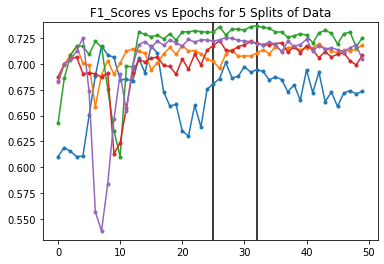

In [134]:
## This yields the best result: By concatenating the titles and doc data and using the combination of parameters as specified below,
## we can obtain ~ 71.11 f1 score and a steady ~70 f1 score across many epochs.
u = np.array((f1_f1_list[49][0])).reshape(1,50)[0]
v = np.array((f1_f1_list[99][0])).reshape(1,50)[0]
w = np.array((f1_f1_list[149][0])).reshape(1,50)[0]
x = np.array((f1_f1_list[199][0])).reshape(1,50)[0]
y = np.array((f1_f1_list[249][0])).reshape(1,50)[0]

six_filters_lr_08_batch_32_with_titles = ((u+v+w+x+y)/5).reshape(1, 50)
#six_filters_lr_07_batch_32
split1  = np.array([0.61043934, 0.61909549, 0.61535965, 0.61039372, 0.61084116,
       0.65007571, 0.68809939, 0.71741769, 0.70857105, 0.70611819,
       0.68449159, 0.68515931, 0.68315048, 0.70519115, 0.69133572,
       0.71737015, 0.71020724, 0.67302705, 0.65923203, 0.66069348,
       0.6350334 , 0.63028873, 0.65992593, 0.6389408 , 0.67545235,
       0.68077545, 0.68560782, 0.70130023, 0.68650782, 0.68778363,
       0.69722574, 0.69190111, 0.69431992, 0.69271471, 0.68442013,
       0.68743463, 0.6847871 , 0.67289349, 0.67978738, 0.6647929 ,
       0.69406177, 0.67206376, 0.69190111, 0.66333309, 0.67262454,
       0.65878469, 0.671772  , 0.67399862, 0.67098749, 0.67329582])
split2 = np.array([0.68193621, 0.69882142, 0.70880249, 0.71680922, 0.70064101,
       0.69878461, 0.6583316 , 0.68944579, 0.70309524, 0.68969443,
       0.70085212, 0.7121023 , 0.71435483, 0.71262574, 0.70995981,
       0.69436828, 0.70076996, 0.70956159, 0.71578609, 0.70903441,
       0.71764508, 0.7122322 , 0.7127139 , 0.70977414, 0.70413789,
       0.70220926, 0.69547351, 0.70936405, 0.71351852, 0.70716057,
       0.7076925 , 0.70750473, 0.71035282, 0.71364642, 0.70967236,
       0.71655399, 0.71243713, 0.71570434, 0.71660401, 0.71323424,
       0.7155215 , 0.7155757 , 0.71906123, 0.71472847, 0.71271177,
       0.71037155, 0.71303889, 0.71218091, 0.71433936, 0.71793002])
split3 = np.array([0.64250833, 0.68599157, 0.70812255, 0.71679186, 0.71688748,
       0.70903768, 0.72155063, 0.71626208, 0.67586134, 0.63540486,
       0.61041438, 0.69760746, 0.697111  , 0.73072131, 0.72827908,
       0.72621637, 0.72763777, 0.72404136, 0.72904852, 0.72274857,
       0.7308795 , 0.73078895, 0.73189848, 0.73106432, 0.7305378 ,
       0.73061476, 0.73581535, 0.72778252, 0.73332083, 0.7334451 ,
       0.73244879, 0.73589783, 0.73669223, 0.73515311, 0.7344007 ,
       0.7306631 , 0.73068722, 0.72544359, 0.72711822, 0.72889221,
       0.72762338, 0.72002591, 0.72988395, 0.73224876, 0.72959305,
       0.71911178, 0.72903792, 0.73059742, 0.71636084, 0.72520784])
split4 = np.array([0.68730232, 0.69970006, 0.70443232, 0.70653984, 0.69053275,
       0.69135108, 0.690258  , 0.68705579, 0.69103916, 0.61297163,
       0.62372059, 0.65753242, 0.69134719, 0.70402189, 0.70183612,
       0.70565771, 0.70636264, 0.69848488, 0.69737825, 0.68997327,
       0.70463925, 0.69486796, 0.7091611 , 0.69893639, 0.71326823,
       0.71757264, 0.72236299, 0.71326823, 0.71249682, 0.7166785 ,
       0.71820848, 0.72165573, 0.71996369, 0.71799397, 0.71841048,
       0.71945202, 0.72027138, 0.71123043, 0.71657164, 0.7107563 ,
       0.7175513 , 0.7133187 , 0.70587306, 0.71173154, 0.70655949,
       0.7092659 , 0.71064897, 0.70287753, 0.69895026, 0.70829401])
split5 = np.array([0.66473411, 0.69155439, 0.70033293, 0.71931834, 0.70215312,
       0.60501638, 0.54096076, 0.63421409, 0.6760668 , 0.68994046,
       0.71593365, 0.72026236, 0.71705887, 0.71466016, 0.71773404,
       0.71517869, 0.71774037, 0.7090054 , 0.71278323, 0.71952897,
       0.70790835, 0.71418656, 0.70985039, 0.71263168, 0.71089151,
       0.71372193, 0.71328308, 0.71720143, 0.71594904, 0.71492256,
       0.71189583, 0.71208702, 0.71030372, 0.70606319, 0.71305071,
       0.7126652 , 0.70832862, 0.70714559, 0.69614441, 0.70400927,
       0.70665586, 0.70587672, 0.70927053, 0.70733607, 0.70734389,
       0.70817477, 0.70912539, 0.70697674, 0.7126515 , 0.70528558])

six_filters_lr_08_batch_32_average_with_titles = np.array([[0.66102655, 0.6807622 , 0.68815854, 0.69253158, 0.68881028,
        0.68449993, 0.66309716, 0.66973215, 0.67258594, 0.65811   ,
        0.66196086, 0.68129622, 0.69667215, 0.71421494, 0.71058003,
        0.71193887, 0.71336594, 0.70463296, 0.7048736 , 0.70054044,
        0.70105005, 0.69835677, 0.706938  , 0.7003709 , 0.70929333,
        0.71060484, 0.7124937 , 0.715376  , 0.71406059, 0.71354734,
        0.71551163, 0.71566759, 0.7161294 , 0.71560409, 0.7135528 ,
        0.7146122 , 0.71192104, 0.70940186, 0.71138299, 0.70723612,
        0.7156822 , 0.7066982 , 0.71284518, 0.70721216, 0.7074202 ,
        0.70220773, 0.70725666, 0.70699754, 0.70379702, 0.70577292]])

epochs = np.array(range(50))

## Plotting the epochs vs f1_score to determine what range of epochs should be be used to train final model 

import matplotlib.pyplot as plt
from matplotlib.pyplot import vlines
plt.title("F1_Scores vs Epochs for 5 Splits of Data")
plt.plot(epochs, u, marker = ".")
plt.plot(epochs, v, marker = ".")
plt.plot(epochs, w, marker = ".")
plt.plot(epochs, x, marker = ".")
plt.plot(epochs, y, marker = ".")
plt.vlines(25, ymin = .530 ,ymax = .740)
plt.vlines(32, ymin = .530 ,ymax = .740)
plt.ylim((.530, .740))


## Based on Graph Above, How do We Choose the Optimal Epoch?

The line graph above displays the f1_score vs epoch. Good epoch selection comes to the the following properties:

--> 1) Low Variance Between Datasplits: The data splits (different colored lines) should be close to each other for a range of epochs. For instance, from the epochs in the range (0,10), this would not be a good epoch use when training our final model because of the large variance between the data splits. All of the data splits are not moving together in a systematic fashion. Thus, if we choose an epoch here, even if it has a high average f1_score, the variance between the data splits in this area of epochs is too high to validate the selection of an epoch within this range.


--> 2) Stability of between Epochs: We want to choose a range of values where the f1_values are relatively consistent. This maximizes are chance of selecting an ideal epoch for our final model. Again, this decision also comes down to variance, we want to minimize the variance among epochs when we make our decision of what epoch is best. 

The black vertical lines above denote the range of values where there is both low variance (small vertical variance) among the data splits and stability (small horizontal variance) among the epochs. We choose 32 as are epoch for training. 




## Below we will train the model on the entire training set to obtain the weights (32 epochs)

In [149]:
# training the CNN model

best_f1 = -1.
#best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm

train_docs = combined3
train_labels = labels
#***********************************************************#
## We vary the below values.
dropout_rate = 0.5 # dropout rate
filter_sizes = [1,2,3,4, 5, 6]
filter_nums = [200]*len(filter_sizes)
word_vec_dim = 300
# hyper parameters

##############################################################
n_epochs = 33 # number of epoch (i.e. number of iterations) --> Setting this value to 32 for reasons as specified earlier
##############################################################
batch_size = 50
lr = 0.0008

#************************************************************#
gpu = True # whether use gpu to accelerate the training
model = CNN_Clf(word_vec_dim, filter_sizes, filter_nums, 2, dropout_rate, gpu)
loss_fnc = torch.nn.CrossEntropyLoss() # cross entropy loss


train_docs = combined3
# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95) # after each epoch, the learning rate is discounted to its 95%
f1_list = []
for epoch_i in tqdm(range(n_epochs)):
    # the inner loop is over the batches in the dataset
    model.train() # let pytorch know that gradients should be computed, so as to update the model
    ep_loss = []
    for idx in range(0,len(train_docs),batch_size):
        # Step 0: Get the data
        x_data = build_mini_batch(train_docs[idx:idx+batch_size], word_vectors)
        if x_data.shape[0] == 0: continue # to avoid empty batch
        y_target = torch.tensor([train_labels[idx:idx+batch_size]], dtype=torch.int64).squeeze()
        if gpu:
            y_target = y_target.to('cuda')
        
        # Step 1: Clear the gradients 
        optimizer.zero_grad()

        # Step 2: Compute the forward pass of the model
        x_tensor = torch.tensor(x_data, dtype=torch.float)
        if gpu:
            x_tensor = x_tensor.to('cuda')
        y_pred = model(x_tensor)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        # print('pred labels', pred_labels)
        # print('true labels', y_target)

        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_fnc(y_pred, y_target)
        # print(loss)
        ep_loss.append(loss.cpu().detach().numpy())

        # Step 4: Propagate the loss signal backward
        loss.backward()

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
    
    print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
    
    




  0%|          | 0/33 [00:00<?, ?it/s]

  3%|▎         | 1/33 [00:13<07:07, 13.34s/it]


======epoch 0 loss====== 0.5480079




  6%|▌         | 2/33 [00:26<06:55, 13.42s/it]


======epoch 1 loss====== 0.47247425




  9%|▉         | 3/33 [00:40<06:43, 13.45s/it]


======epoch 2 loss====== 0.43082878




 12%|█▏        | 4/33 [00:53<06:30, 13.45s/it]


======epoch 3 loss====== 0.38193598




 15%|█▌        | 5/33 [01:07<06:15, 13.41s/it]


======epoch 4 loss====== 0.3393407




 18%|█▊        | 6/33 [01:20<06:01, 13.40s/it]


======epoch 5 loss====== 0.29982936




 21%|██        | 7/33 [01:33<05:47, 13.38s/it]


======epoch 6 loss====== 0.26097265




 24%|██▍       | 8/33 [01:47<05:34, 13.37s/it]


======epoch 7 loss====== 0.23728448




 27%|██▋       | 9/33 [02:00<05:19, 13.33s/it]


======epoch 8 loss====== 0.20793061




 30%|███       | 10/33 [02:13<05:04, 13.25s/it]


======epoch 9 loss====== 0.16774409




 33%|███▎      | 11/33 [02:26<04:51, 13.24s/it]


======epoch 10 loss====== 0.14394315




 36%|███▋      | 12/33 [02:39<04:37, 13.21s/it]


======epoch 11 loss====== 0.122690186




 39%|███▉      | 13/33 [02:52<04:22, 13.14s/it]


======epoch 12 loss====== 0.118754044




 42%|████▏     | 14/33 [03:05<04:09, 13.11s/it]


======epoch 13 loss====== 0.10440138




 45%|████▌     | 15/33 [03:18<03:54, 13.04s/it]


======epoch 14 loss====== 0.09739707




 48%|████▊     | 16/33 [03:31<03:41, 13.01s/it]


======epoch 15 loss====== 0.0989939




 52%|█████▏    | 17/33 [03:44<03:27, 12.97s/it]


======epoch 16 loss====== 0.10328698




 55%|█████▍    | 18/33 [03:57<03:14, 12.97s/it]


======epoch 17 loss====== 0.11194124




 58%|█████▊    | 19/33 [04:10<03:00, 12.93s/it]


======epoch 18 loss====== 0.087551564




 61%|██████    | 20/33 [04:23<02:47, 12.88s/it]


======epoch 19 loss====== 0.08616932




 64%|██████▎   | 21/33 [04:36<02:34, 12.86s/it]


======epoch 20 loss====== 0.07871238




 67%|██████▋   | 22/33 [04:48<02:21, 12.83s/it]


======epoch 21 loss====== 0.07531715




 70%|██████▉   | 23/33 [05:01<02:08, 12.82s/it]


======epoch 22 loss====== 0.06914431




 73%|███████▎  | 24/33 [05:14<01:56, 12.90s/it]


======epoch 23 loss====== 0.06867829




 76%|███████▌  | 25/33 [05:27<01:43, 12.95s/it]


======epoch 24 loss====== 0.060100395




 79%|███████▉  | 26/33 [05:40<01:31, 13.01s/it]


======epoch 25 loss====== 0.068915084




 82%|████████▏ | 27/33 [05:53<01:18, 13.04s/it]


======epoch 26 loss====== 0.067730814




 85%|████████▍ | 28/33 [06:07<01:05, 13.08s/it]


======epoch 27 loss====== 0.07179834




 88%|████████▊ | 29/33 [06:20<00:52, 13.19s/it]


======epoch 28 loss====== 0.056401733




 91%|█████████ | 30/33 [06:33<00:39, 13.17s/it]


======epoch 29 loss====== 0.069798164




 94%|█████████▍| 31/33 [06:46<00:26, 13.19s/it]


======epoch 30 loss====== 0.06454318




 97%|█████████▋| 32/33 [06:59<00:13, 13.12s/it]


======epoch 31 loss====== 0.06970759




100%|██████████| 33/33 [07:12<00:00, 13.06s/it]




======epoch 32 loss====== 0.077708505


## Now We Will Explore a more simple machine learning model; namely the Logistic Regression Classification Model 

In [170]:
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression()),
])


parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000, 100000),
    'vect__ngram_range': ((1, 2), (1,3), (1,5)),  # unigrams or bigrams,
    'vect__max_features': (1000, 10000, 30000, 50000, 70000, 100000),
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    #'clf__max_iter': (20,),
    'clf__C': (5, 10, 20, 30, 40, 100),
    #'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = 'f1_macro', cv = 4)
grid_search.fit(combined3, labels)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 42.5min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 44.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    htt

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

#### A rudimentary grid search of a logistic regression model coupled with the tdf-idf vectorizer yields the best model with params printed below. 

In [178]:
print(grid_search.best_params_)



{'clf__C': 20, 'vect__max_df': 1.0, 'vect__max_features': 100000, 'vect__ngram_range': (1, 3)}


### Now lets test the the CNN model and the logistic regression model on the same training_validation splits.

In [15]:
x_train6, x_dev6, y_train6, y_dev6= train_test_split(combined3, labels,  train_size = 0.7, test_size = 0.3, stratify = labels, random_state = 787)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


################################################ LOGISIC REGRESSION PART ##########################################################
max_feature_num = 100000
train_vectorizer = TfidfVectorizer(ngram_range = (1,3), max_features = max_feature_num)
all_vecs = train_vectorizer.fit_transform(x_train6)
test_vecs = TfidfVectorizer(ngram_range = (1,3), max_features=max_feature_num,\
 vocabulary = train_vectorizer.vocabulary_).fit_transform(x_dev6)
clf_fit = LogisticRegression(penalty = 'l2', C = 20)
clf_fit.fit(all_vecs,  y_train6)

################################################ LOGISIC REGRESSION PART ##########################################################


############################################## CONVOLUTION NEURAL NET PART ########################################################
best_f1 = -1.
#best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm

train_docs = x_train6
train_labels = y_train6
#***********************************************************#
## We vary the below values.
dropout_rate = 0.5 # dropout rate
filter_sizes = [1,2,3,4, 5, 6]
filter_nums = [200]*len(filter_sizes)
word_vec_dim = 300
# hyper parameters

##############################################################
n_epochs = 33 # number of epoch (i.e. number of iterations) --> Setting this value to 32 for reasons as specified earlier
##############################################################
batch_size = 50
lr = 0.0008

#************************************************************#
gpu = True # whether use gpu to accelerate the training
model = CNN_Clf(word_vec_dim, filter_sizes, filter_nums, 2, dropout_rate, gpu)
loss_fnc = torch.nn.CrossEntropyLoss() # cross entropy loss

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95) # after each epoch, the learning rate is discounted to its 95%
f1_list = []

oov_vec = oov_vec
def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    for i in range(largest_len-len(sent_words)):
        vecs.append([0.]*word_vec_dim)
    return np.array(np.transpose(vecs))

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs.append(vv)
    # print('mini batch shape',np.array(text_vecs).shape)
    return np.array(text_vecs)
  
for epoch_i in tqdm(range(n_epochs)):
    # the inner loop is over the batches in the dataset
    model.train() # let pytorch know that gradients should be computed, so as to update the model
    ep_loss = []
    for idx in range(0,len(train_docs),batch_size):
        # Step 0: Get the data
        x_data = build_mini_batch(train_docs[idx:idx+batch_size], word_vectors)
        if x_data.shape[0] == 0: continue # to avoid empty batch
        y_target = torch.tensor([train_labels[idx:idx+batch_size]], dtype=torch.int64).squeeze()
        if gpu:
            y_target = y_target.to('cuda')
        
        # Step 1: Clear the gradients 
        optimizer.zero_grad()

        # Step 2: Compute the forward pass of the model
        x_tensor = torch.tensor(x_data, dtype=torch.float)
        if gpu:
            x_tensor = x_tensor.to('cuda')
        y_pred = model(x_tensor)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        # print('pred labels', pred_labels)
        # print('true labels', y_target)

        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_fnc(y_pred, y_target)
        # print(loss)
        ep_loss.append(loss.cpu().detach().numpy())

        # Step 4: Propagate the loss signal backward
        loss.backward()

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()

    print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
    
############################################## CONVOLUTION NEURAL NET PART ########################################################




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
  3%|▎         | 1/33 [00:10<05:29, 10.30s/it]


======epoch 0 loss====== 0.558586


  6%|▌         | 2/33 [00:20<05:14, 10.15s/it]


======epoch 1 loss====== 0.4710662


  9%|▉         | 3/33 [00:29<05:01, 10.05s/it]


======epoch 2 loss====== 0.41341794


 12%|█▏        | 4/33 [00:39<04:49,  9.98s/it]


======epoch 3 loss====== 0.36613747


 15%|█▌        | 5/33 [00:49<04:38,  9.94s/it]


======epoch 4 loss====== 0.32296184


 18%|█▊        | 6/33 [00:59<04:27,  9.90s/it]


======epoch 5 loss====== 0.28878438


 21%|██        | 7/33 [01:09<04:16,  9.88s/it]


======epoch 6 loss====== 0.24373434


 24%|██▍       | 8/33 [01:19<04:06,  9.86s/it]


======epoch 7 loss====== 0.20291135


 27%|██▋       | 9/33 [01:28<03:56,  9.84s/it]


======epoch 8 loss====== 0.16897112


 30%|███       | 10/33 [01:38<03:45,  9.82s/it]


======epoch 9 loss====== 0.1542105


 33%|███▎      | 11/33 [01:48<03:35,  9.80s/it]


======epoch 10 loss====== 0.1393834


 36%|███▋      | 12/33 [01:58<03:25,  9.79s/it]


======epoch 11 loss====== 0.14129591


 39%|███▉      | 13/33 [02:07<03:15,  9.79s/it]


======epoch 12 loss====== 0.14127313


 42%|████▏     | 14/33 [02:17<03:05,  9.78s/it]


======epoch 13 loss====== 0.13455874


 45%|████▌     | 15/33 [02:27<02:55,  9.76s/it]


======epoch 14 loss====== 0.10825079


 48%|████▊     | 16/33 [02:37<02:45,  9.76s/it]


======epoch 15 loss====== 0.09897812


 52%|█████▏    | 17/33 [02:46<02:36,  9.76s/it]


======epoch 16 loss====== 0.09027867


 55%|█████▍    | 18/33 [02:56<02:26,  9.76s/it]


======epoch 17 loss====== 0.07850769


 58%|█████▊    | 19/33 [03:06<02:17,  9.79s/it]


======epoch 18 loss====== 0.07618548


 61%|██████    | 20/33 [03:16<02:07,  9.78s/it]


======epoch 19 loss====== 0.07990263


 64%|██████▎   | 21/33 [03:26<01:57,  9.77s/it]


======epoch 20 loss====== 0.07971493


 67%|██████▋   | 22/33 [03:35<01:47,  9.77s/it]


======epoch 21 loss====== 0.06450906


 70%|██████▉   | 23/33 [03:45<01:37,  9.78s/it]


======epoch 22 loss====== 0.055367187


 73%|███████▎  | 24/33 [03:55<01:27,  9.77s/it]


======epoch 23 loss====== 0.056118272


 76%|███████▌  | 25/33 [04:05<01:18,  9.77s/it]


======epoch 24 loss====== 0.057179403


 79%|███████▉  | 26/33 [04:14<01:08,  9.79s/it]


======epoch 25 loss====== 0.05435437


 82%|████████▏ | 27/33 [04:24<00:58,  9.79s/it]


======epoch 26 loss====== 0.056699622


 85%|████████▍ | 28/33 [04:34<00:48,  9.78s/it]


======epoch 27 loss====== 0.047476638


 88%|████████▊ | 29/33 [04:44<00:39,  9.76s/it]


======epoch 28 loss====== 0.048329238


 91%|█████████ | 30/33 [04:53<00:29,  9.75s/it]


======epoch 29 loss====== 0.043283917


 94%|█████████▍| 31/33 [05:03<00:19,  9.74s/it]


======epoch 30 loss====== 0.04211143


 97%|█████████▋| 32/33 [05:13<00:09,  9.73s/it]


======epoch 31 loss====== 0.04257398


100%|██████████| 33/33 [05:23<00:00,  9.73s/it]


======epoch 32 loss====== 0.03767485


In [0]:
## LOGISTIC REGResSION PREDICTIONS
logistic_predictions = clf_fit.predict(test_vecs)

### CNN PREDICTIONS
gpu = True
dev_docs = x_dev6
with torch.no_grad(): # let pytorch know that no gradient should be computed
  model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
  dev_predictions = []
  x_data = build_mini_batch(dev_docs, word_vectors)
  # if x_data.shape[0] == 0: 
  #   continue # to avoid empty batch
  x_tensor = torch.tensor(x_data, dtype=torch.float)
  if gpu:
      x_tensor = x_tensor.to('cuda')
  y_pred = model(x_tensor).cpu().detach().numpy()
  pred_labels = [np.argmax(entry) for entry in y_pred]
            #dev_predictions += pred_labels
            # print(pred_labels)
       # pre, rec, f1, _ = precision_recall_fscore_support(dev_labels, dev_predictions,average='macro')
cnn_predictions = pred_labels
#confusion_matrix(logistic_predictions,


In [30]:
print(confusion_matrix(logistic_predictions, y_dev6))
print(confusion_matrix(cnn_predictions, y_dev6))

print("true negatives,", "false negatives")
print("true positives," " ", "false positives")

print(" ")
print("precision_recall_fscore Logistic Predictions:", precision_recall_fscore_support(logistic_predictions, y_dev6,average='macro'))
print("precision_recall_fscore CNN Neural predictions:", precision_recall_fscore_support(cnn_predictions, y_dev6,average='macro'))

print(" ")

print('logistic accuracy:', np.sum(np.array(logistic_predictions) == np.array(y_dev6))/len(logistic_predictions)   )
print('cnn accuracy:', np.sum(np.array(cnn_predictions) == np.array(y_dev6))/len(cnn_predictions))

[[2167  547]
 [ 302  424]]
[[1973  368]
 [ 496  603]]
true negatives, false negatives
true positives,  false positives
 
precision_recall_fscore Logistic Predictions: (0.6571732531798002, 0.6912372536242035, 0.667950308059154, None)
precision_recall_fscore CNN Neural predictions: (0.7100591098936806, 0.6957414200086367, 0.7014914580131972, None)
 
logistic accuracy: 0.7531976744186046
cnn accuracy: 0.7488372093023256


### Which is the Better Model: Convolution Neural Network or Logistic Regression (See printed values above)

As you can see above, although the logistic and CNN accuracies are relatively close, we can see that our CNN is better in almost every other category. These are the categories it is better in:

a) The Convolutional Neural Net has a much lower false positive rate (as shown by the much higher precision). It has a lower tendency to misclassify non-propaganda texts as propaganda texts.

b) The CNN also has a much lower tendency to misclassify propaganda text as non-propaganda text. Hence, it has a better recall.

Thus, with this in mind we can see that the convolutional neural net is a better model than the logistic regression.

## SAVE YOUR TRAINED MODEL
After you have obtained the best model, save your trained model and other necessary components to a file. The markers will load your model from the saved file and test your trained model on some held-out test data. Make sure that you have included all necessary files to re-run your model. **The markers will NOT re-run your code to train your model; instead, they will directly use your trained model to run the test**. 

Below is the sample code for saving the model and other necessary components, using the *pickle* package in Python. *You should adjust the code to save all necessary components for re-running your model.*

In [0]:
import pickle

# save model and other necessary components of your model
# DO NOT include the embedding files in your submission
word_vec_dim = 300
dropout_rate = 0.5
oov_vec
all_info_want_to_save = {
    'input_dim': word_vec_dim,
    'dropout_rate': dropout_rate,
    'neural_weights': model.state_dict(),
    'oov_vector': oov_vec,
    'filter_size_list': [1,2,3,4,5,6],
    'filter_num_list': [200, 200, 200, 200, 200, 200],
    'class_num': 2

}
save_path = open("cw2_sample_saved_file.pickle","wb")
pickle.dump(all_info_want_to_save, save_path)
save_path.close()